# Домашнее задание №2

Выполнил: Хайкин Г.А., БЭК1812

Данные: Росстат, 2011 год


Загрузим необходимые библиотеки:

In [1]:
library("readxl") # чтение excel-файла
library("tidyverse") # коллекция пакетов: ggplot2, dplyr, etc.
library("knitr") # создание отчётов
library("lmtest") # тесты для линейных моделей
library("memisc") # сравнение моделей
library("pander") # таблички в markdown
library("psych") # описательные статистики
library("modelr") # добавление прогнозов/остатков
library("MASS") # тест Бокса-Кокса
library("remotes") # тест Рамсея
library("car") # vif()
library("caret")
library("nortest") 
library("stats")
library("visreg") 


# Отрегулируем размер картинок
library("repr")
options(repr.plot.width=10, repr.plot.height=8)

── Attaching packages ───────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘memisc’


The following objects are masked from ‘package:dplyr’:

    collect, recode, rename, syms


The following object is masked from ‘package:purrr’:

    %@%


The following object is masked from ‘packag

## Часть 1

### 1.

Выгрузим данные из заранее подготовленного эксель файла.

In [2]:
df <- read_excel("data_new.xlsx")
head(df)

Regions,Unemployment,GRP_RUB,Consumer_Basket,GRP_per_capita,Urban_Share,Higher_Education,West,GRP_Percentage,GRP_Change,Unemployment_2010,Unemployment_2011,Unemployment_Change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Белгородская область,4.4,331010.0,86,384895.3,66.4,28.6,1,111.0,11.0,5.2,4.4,-0.8
Брянская область,7.1,137187.1,87,157686.3,69.2,24.1,1,108.2,8.2,8.0,7.1,-0.9
Владимирская область,5.8,181842.6,97,187466.6,77.6,23.3,1,102.9,2.9,6.2,5.8,-0.4
Воронежская область,6.6,203575.5,98,207730.1,65.9,27.0,1,111.4,11.4,7.5,6.6,-0.9
Ивановская область,6.6,121945.5,92,132549.5,81.0,26.2,1,100.6,0.6,7.6,6.6,-1.0
Калужская область,5.6,232722.0,90,258580.0,75.9,24.9,1,112.9,12.9,6.5,5.6,-0.9


In [3]:
tail(df)

Regions,Unemployment,GRP_RUB,Consumer_Basket,GRP_per_capita,Urban_Share,Higher_Education,West,GRP_Percentage,GRP_Change,Unemployment_2010,Unemployment_2011,Unemployment_Change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Хабаровский край,6.8,297609.2,133,223766.3,81.5,31.8,0,102.5,2.5,9.1,6.8,-2.3
Амурская область,6.1,273175.8,115,237544.2,67.0,26.1,0,108.1,8.1,6.9,6.1,-0.8
Магаданская область,4.5,464112.9,148,313589.8,95.7,31.3,0,102.4,2.4,5.7,4.5,-1.2
Сахалинская область,8.2,1210003.9,146,828769.8,80.3,23.6,0,104.3,4.3,9.3,8.2,-1.1
Еврейская автономная область,8.8,225065.5,118,190733.5,68.1,18.8,0,104.8,4.8,9.4,8.8,-0.6
Чукотский автономный округ,5.4,883368.7,176,501914.0,66.0,27.7,0,95.8,-4.2,4.1,5.4,1.3


Сделаем факторинг для облегчения построения графиков:

In [4]:
df$f.West <- factor(df$West, levels=c(0, 1), labels=c("East", "West"))

In [5]:
table(df$f.West)


East West 
  27   56 

Удалим далее ненужные столбцы:

In [6]:
df <- subset(df, select = -c(GRP_RUB, Consumer_Basket, GRP_Percentage, Unemployment_2010, Unemployment_2011))

Зависимая переменная: 
* `Unemployment` — уровень безработицы (%).

Объясняющие переменные:
* `GRP_per_capita` — валовой региональный продукт на душу населения с учетом паритета покупательной способности;
* `Urban_Share` — удельный вес городского населения;
* `Higher_Education` — доля занятого населения, имеющего высшее образование;
* `West` — дамми-переменная, принимающая 1 для западный регионов и 0 для восточных.

### 2. 

Оценим зависимость изменения безработицы от изменения ВРП (данные из д/з №1), добавив дамми-переменные для дифференциации свободного члена и коэффициента наклона.

То есть необходимо построить следующую регрессию:

$y = \beta_0 + \delta_0 d^{(0)} + \beta_1 x + \delta_1 d^{(1)} + \varepsilon$, где $d^{(0)}$ — вектор дамми-переменных для дифференциации свободного члена, $d^{(1)}$ — вектор дамми-переменных для дифференциации коэффициента наклона.

Следовательно, регрессия имеет вид:

* для восточных регионов: $\text{Unemployment_Change}_i^{east} = \beta_0 + \beta_1 \text{GRP_Change}_i + \varepsilon_i$
* для западных регионов: $\text{Unemployment_Change}_i^{west} = \beta^{'}_0 + \beta^{'}_1 \text{GRP_Change}_i + \varepsilon_i = (\beta_0 + \delta_0) + (\beta_1 + \delta_1) \text{GRP_Change}_i + \varepsilon_i$


Можем записать нашу регрессию как:

$\text{Unemployment_Change}_i = \beta_0 + \delta_0 \text{West}_i + \beta_1 \text{GRP_Change}_i + \delta_1(\text{West}_i \times \text{GRP_Change}_i) + \varepsilon_i$


In [7]:
lr <- lm(Unemployment_Change ~ West + GRP_Change + (West * GRP_Change), data = df)
lr


Call:
lm(formula = Unemployment_Change ~ West + GRP_Change + (West * 
    GRP_Change), data = df)

Coefficients:
    (Intercept)             West       GRP_Change  West:GRP_Change  
       -0.60890          0.26003         -0.05122         -0.04926  


Получили следующее:
* для восточных регионов:

$\widehat{\text{Unemployment_Change}}^{east}_i \approx − 0.61 -0.05 \times \text{GRP_Change}_i$
* для западных регионов: 

$\widehat{\text{Unemployment_Change}}^{west}_i \approx -0.35 -0.1 \times \text{GRP_Change}_i$


Посмотрим на итоговые результаты:

In [8]:
summary(lr)


Call:
lm(formula = Unemployment_Change ~ West + GRP_Change + (West * 
    GRP_Change), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3679 -0.4872  0.1221  0.4924  1.9933 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)     -0.60890    0.37276  -1.634    0.106
West             0.26003    0.45827   0.567    0.572
GRP_Change      -0.05122    0.07182  -0.713    0.478
West:GRP_Change -0.04926    0.08107  -0.608    0.545

Residual standard error: 1.038 on 79 degrees of freedom
Multiple R-squared:  0.091,	Adjusted R-squared:  0.05648 
F-statistic: 2.636 on 3 and 79 DF,  p-value: 0.05543


Как видим, все наши коэффициенты являются незначимыми при любом разумном уровне значимости. Также легко заметить, что по $F$-статистике модель неадекватна (так как $\text{p-value} > 0.05$), а качество регрессии по  $R^2_{adj}$ очень низкое.

Визуализируем полученный результат:

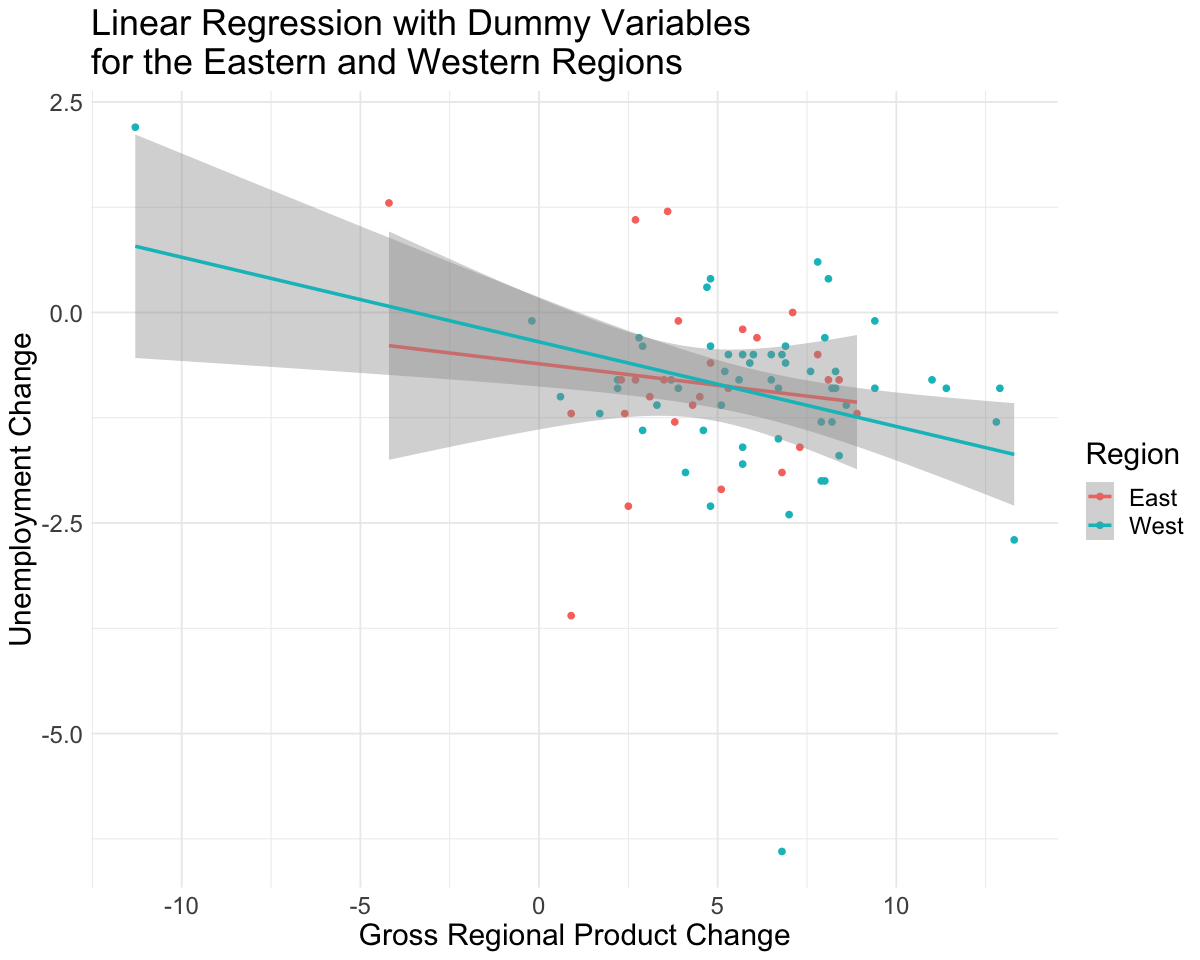

In [9]:
ggplot(df, aes(GRP_Change, Unemployment_Change, color=f.West)) +
    geom_point() + 
    stat_smooth(method = "lm", formula = y ~ x) +
    labs(
    x = "Gross Regional Product Change",
    y = "Unemployment Change",
    color = "Region"
    ) +
    theme_minimal() +
    theme(text = element_text(size=18)) +
    ggtitle("Linear Regression with Dummy Variables \nfor the Eastern and Western Regions")


### 3. Имеет ли место единая зависимость восточных и западных регионов?

Определим две модели.
* Restricted: $y = \beta_0 + \beta_1 x + \varepsilon$
* Unrestricted: $y = \beta_0 + \delta_0 d^{(0)} + \beta_1 x + \delta_1 d^{(1)} + \varepsilon$

#### (a) Проверка гипотезы о значимости дамми-переменных

$
\begin{cases}
H_0: \delta_0 = \delta_1 = 0 \\
H_a: \delta^2_0 + \delta^2_1 > 0
\end{cases}
$

$
F_{obs} = \dfrac{(\text{RSS}_R - \text{RSS}_{UR})/q}{\text{RSS}_{UR} / (n-p)} = \stackrel{H_0}{\sim}  F(q,n-p) 
$, где $q$ — количество ограничений,  $p$ — количество параметров для оценки у UR модели.

1) Найдем $\text{RSS}_{UR}$:

In [10]:
RSS_UR <- sum(residuals(lr)^2)

2) Найдем $\text{RSS}$ модели без деления выборки на восточные и западные регионы, то есть $\text{RSS}_R$:

In [11]:
lr_R <- lm(Unemployment_Change ~ GRP_Change, data=df)

Выведем сводку по данной регрессии:

In [12]:
summary(lr_R)


Call:
lm(formula = Unemployment_Change ~ GRP_Change, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3682 -0.5221  0.1249  0.4853  1.9467 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.42599    0.20999  -2.029  0.04579 * 
GRP_Change  -0.08909    0.03215  -2.772  0.00692 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.028 on 81 degrees of freedom
Multiple R-squared:  0.08662,	Adjusted R-squared:  0.07535 
F-statistic: 7.682 on 1 and 81 DF,  p-value: 0.006918


Визуализируем регрессию:

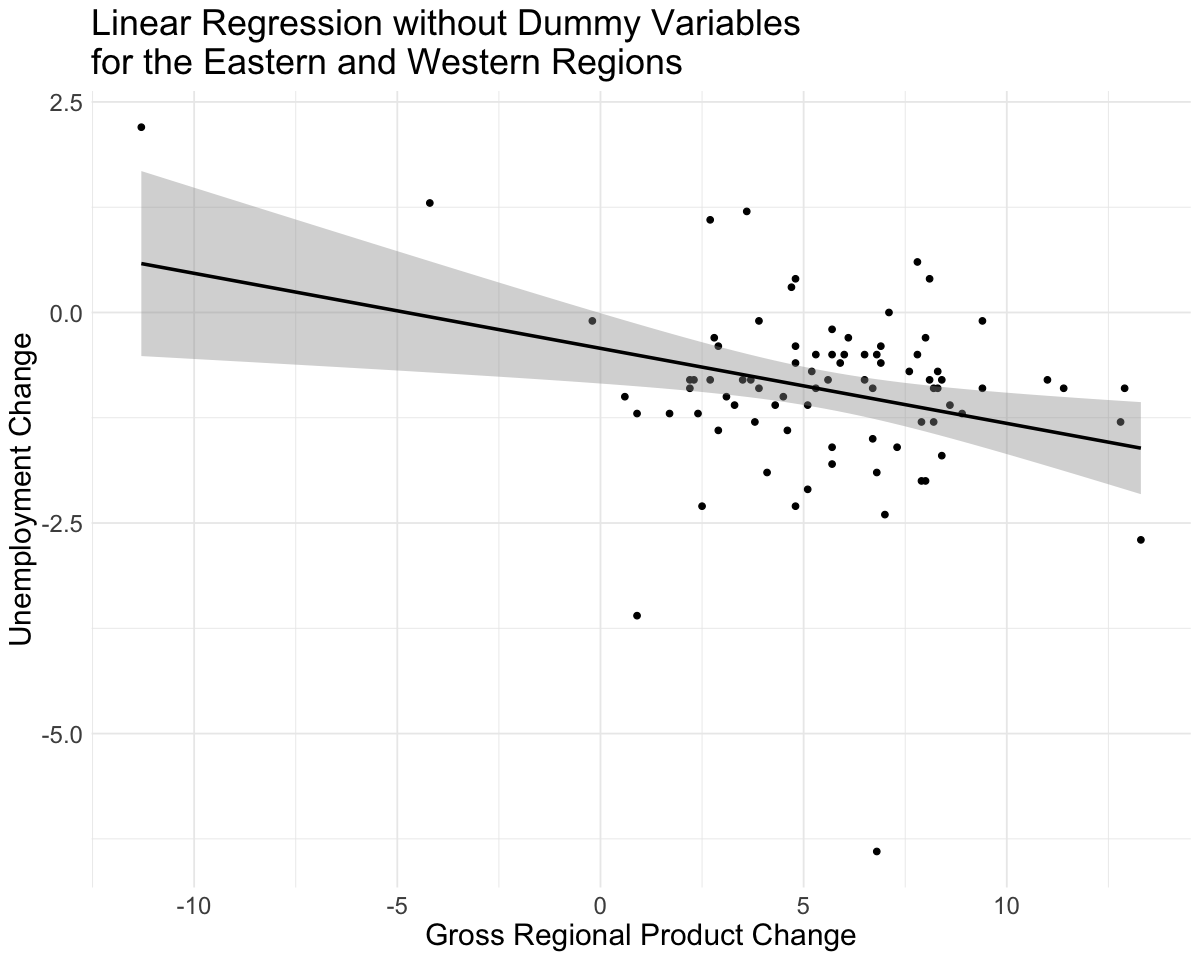

In [13]:
ggplot(df, aes(GRP_Change, Unemployment_Change)) +
    geom_point() + 
    stat_smooth(method = "lm", formula = y ~ x, color="black") +
    labs(
    x = "Gross Regional Product Change",
    y = "Unemployment Change",
    color = "Region"
    ) +
    theme_minimal() +
    theme(text = element_text(size=18)) + 
    ggtitle("Linear Regression without Dummy Variables \nfor the Eastern and Western Regions")

In [14]:
RSS_R <- sum(residuals(lr_R)^2)

In [15]:
RSS_R

[1] 85.5802

3) Посчитаем тестовую статистику:

In [16]:
q = 2
p = 4
n = nrow(df)
f_obs = ((RSS_R - RSS_UR)/q)/(RSS_UR/(n - p))

4) Проверим гипотезу при разумных уровнях значимости:

In [17]:
alpha <- c(0.1, 0.05, 0.01)
f_crit <- qf(1-alpha, df1=q, df2=n-p)

for (i in 1:3) {
    if (f_obs < f_crit[i]) {
        cat(sprintf('H_0 не отвергается при уровне значимости %.2f\n', alpha[i]))
    } else {
        cat(sprintf('H_0 отвергается при уровне значимости %.2f\n', alpha[i]))
    }
}

H_0 не отвергается при уровне значимости 0.10
H_0 не отвергается при уровне значимости 0.05
H_0 не отвергается при уровне значимости 0.01


Как видим, нулевая гипотеза не отвергается при любом разумном уровне значимости — дамми-переменные незначимы. Следовательно, нет различия между восточными и западными регионами в изменении безработицы.

#### (b) Тест Чоу

$
F_{obs} = \dfrac{(\text{RSS}_R - \text{RSS}_{UR})/p}{\text{RSS}_{UR} / (n- 2p)} =  \dfrac{(\text{RSS}_{pooled} - [\text{RSS}_{1} + \text{RSS}_{2}])/p}{(\text{RSS}_{1} + \text{RSS}_{2}) / (n- 2p)} \stackrel{H_0}{\sim} F(p, n - 2p)
$, где $p$ — количество параметров для оценки

1) Cделаем 3 регрессии и вычислим для них $\text{RSS}$:

Общая регрессия:

In [18]:
lr_pooled <- lm(Unemployment_Change ~ GRP_Change, data = df) 
RSS_pooled <- sum(residuals(lr_pooled)^2)

In [19]:
RSS_pooled

[1] 85.5802

Регрессия для восточных регионов:

In [20]:
df_east = subset(df, West == 0)
head(df_east)

Regions,Unemployment,GRP_per_capita,Urban_Share,Higher_Education,West,GRP_Change,Unemployment_Change,f.West
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Курганская область,10.3,165985.05,60.4,22.7,0,6.8,-1.9,East
Свердловская область,7.3,297097.82,84.0,24.2,0,8.9,-1.2,East
Тюменская область,6.2,43146.12,78.7,28.3,0,3.1,-1.0,East
Ханты-Мансийский автономный округ,6.3,1193409.09,91.6,29.8,0,0.9,-1.2,East
Ямало-Ненецкий автономный округ,3.5,1264098.12,85.0,33.9,0,2.7,-0.8,East
Челябинская область,6.7,244685.93,82.1,27.2,0,5.3,-0.9,East


In [21]:
lr_1 <- lm(Unemployment_Change ~ GRP_Change, data = df_east)
RSS_1 <- sum(residuals(lr_1)^2)

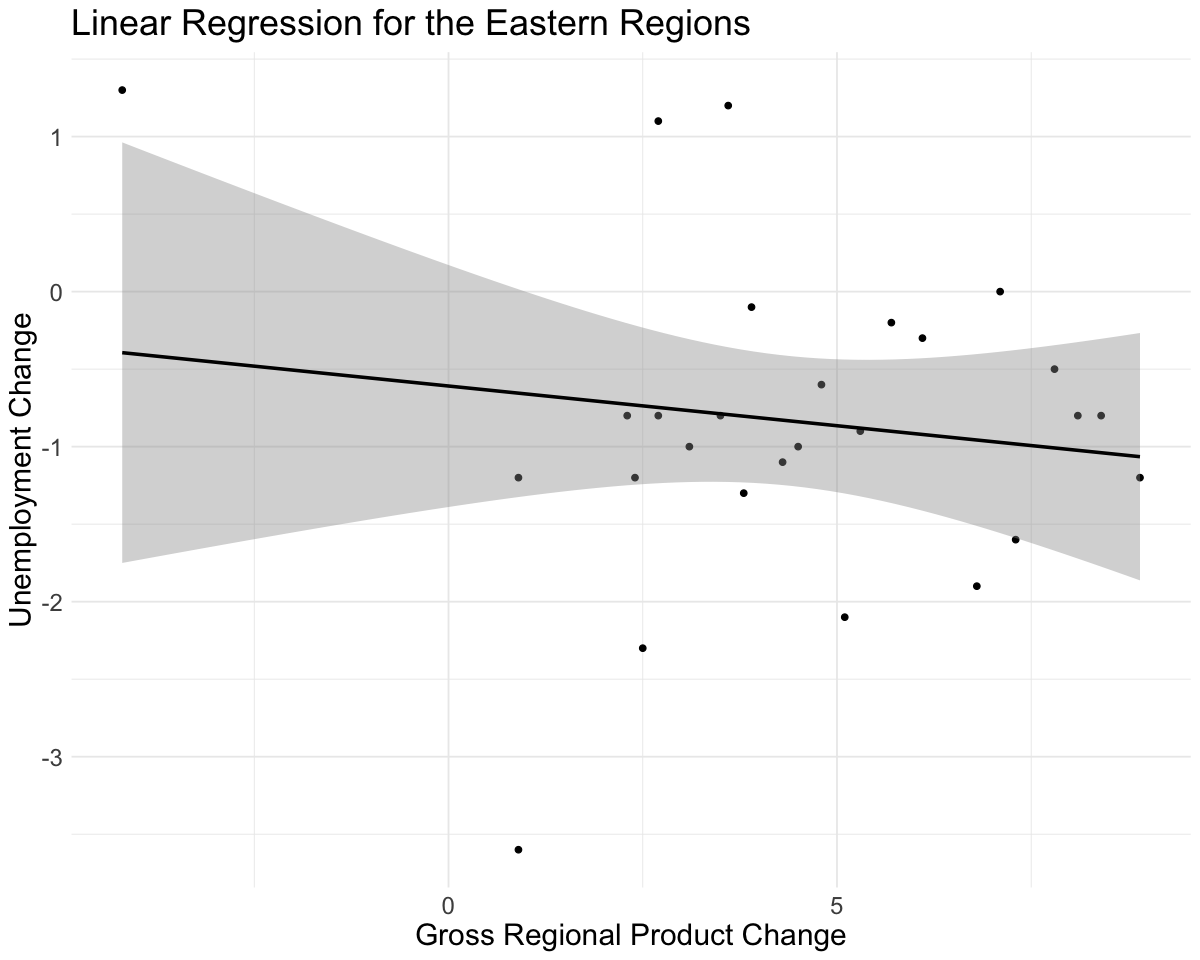

In [22]:
ggplot(df_east, aes(GRP_Change, Unemployment_Change)) +
    geom_point() + 
    stat_smooth(method = "lm", formula = y ~ x, color="black") +
    labs(
    x = "Gross Regional Product Change",
    y = "Unemployment Change",
    color = "Region"
    ) +
    theme_minimal() +
    theme(text = element_text(size=18)) + 
    ggtitle("Linear Regression for the Eastern Regions")

Регрессия для западных регионов:

In [23]:
df_west <- subset(df, West == 1)
head(df_west)

Regions,Unemployment,GRP_per_capita,Urban_Share,Higher_Education,West,GRP_Change,Unemployment_Change,f.West
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Белгородская область,4.4,384895.3,66.4,28.6,1,11.0,-0.8,West
Брянская область,7.1,157686.3,69.2,24.1,1,8.2,-0.9,West
Владимирская область,5.8,187466.6,77.6,23.3,1,2.9,-0.4,West
Воронежская область,6.6,207730.1,65.9,27.0,1,11.4,-0.9,West
Ивановская область,6.6,132549.5,81.0,26.2,1,0.6,-1.0,West
Калужская область,5.6,258580.0,75.9,24.9,1,12.9,-0.9,West


In [24]:
lr_2 <- lm(Unemployment_Change ~ GRP_Change, data = df_west)
RSS_2 <- sum(residuals(lr_2)^2)

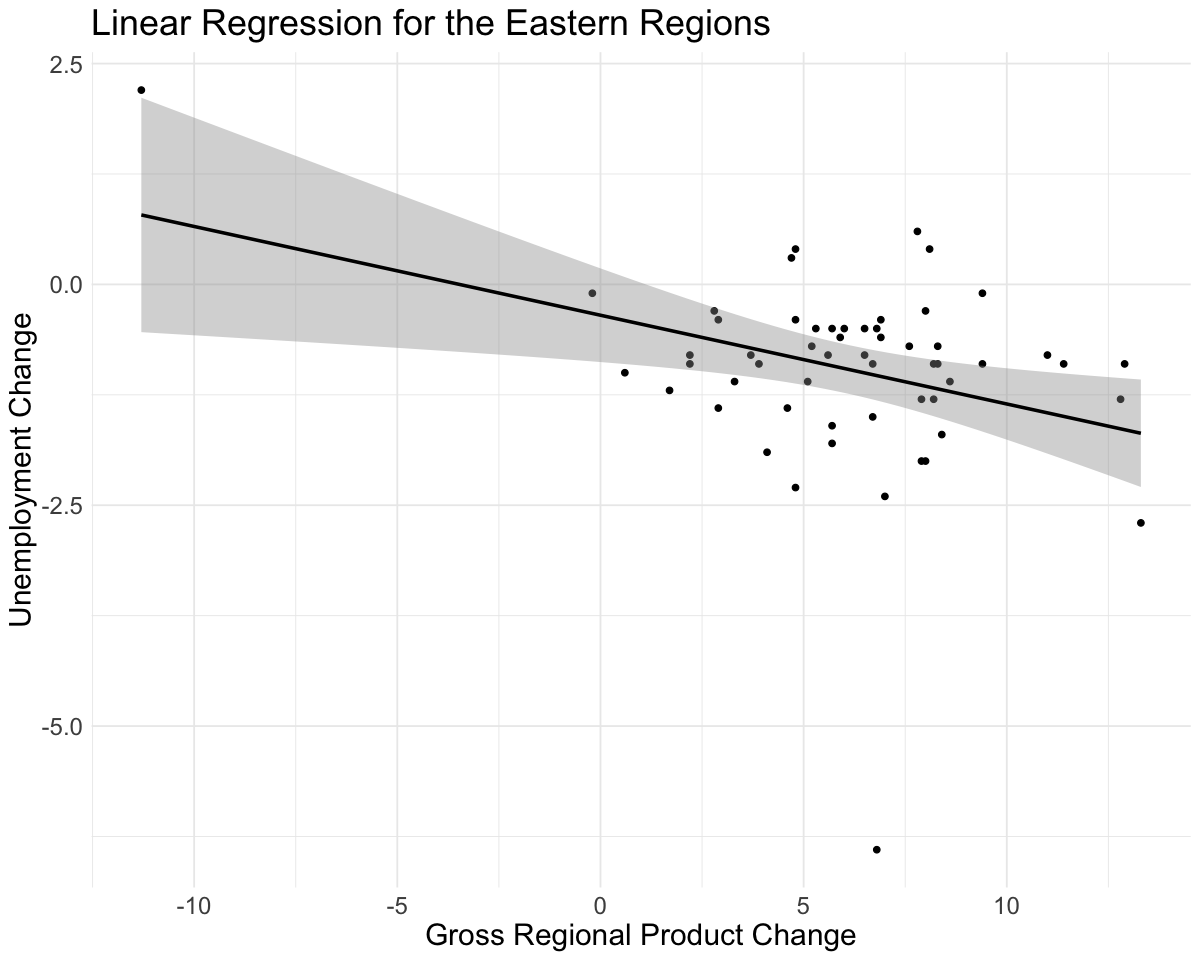

In [25]:
ggplot(df_west, aes(GRP_Change, Unemployment_Change)) +
    geom_point() + 
    stat_smooth(method = "lm", formula = y ~ x, color="black") +
    labs(
    x = "Gross Regional Product Change",
    y = "Unemployment Change",
    color = "Region"
    ) +
    theme_minimal() +
    theme(text = element_text(size=18)) +
    ggtitle("Linear Regression for the Eastern Regions")

2) Вычислим $F$-статистику:

In [26]:
p <- 2
f_obs <- ((RSS_pooled - (RSS_1 + RSS_2))/p)/((RSS_1 + RSS_2)/(n - 2*p))

3) Проверим гипотезу при разумных уровнях значимости:

In [27]:
alpha <- c(0.1, 0.05, 0.01)
f_crit <- qf(1-alpha, df1=p, df2=n-2*p)

for (i in 1:3) {
    if (f_obs < f_crit[i]) {
        cat(sprintf('H_0 не отвергается при уровне значимости %.2f\n', alpha[i]))
    } else {
        cat(sprintf('H_0 отвергается при уровне значимости %.2f\n', alpha[i]))
    }
}

H_0 не отвергается при уровне значимости 0.10
H_0 не отвергается при уровне значимости 0.05
H_0 не отвергается при уровне значимости 0.01


Как видим, нулевая гипотеза не отвергается при любом разумном уровне значимости — дамми-переменные незначимы. Этого и следовало ожидать, поскольку тест Чоу эквивалентен тесту о значимости группы дамми-переменных. __Экономическая интерпретация__: _нет различия_ между восточными и западными регионами в изменении безработицы.

### 4.

Построим диаграмму рассеяния для всех наблюдений, отложив по горизонтальной оси изменение ВРП, а по вертикальной оси — изменение безработицы. На этой же диаграмме проведем линию оцененного уравнения регрессии (без дамми переменных, поскольку они незначимы).

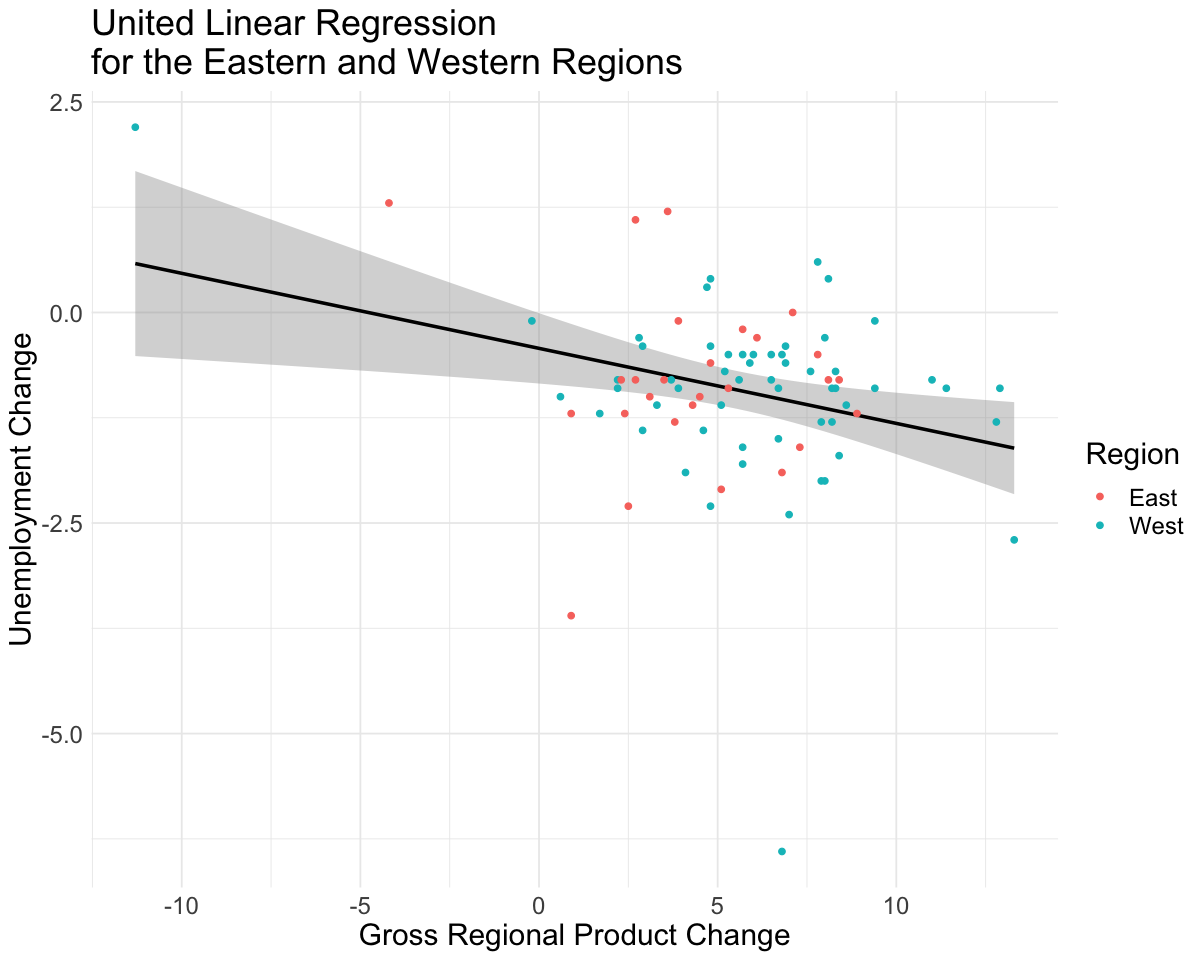

In [28]:
ggplot(df, aes(GRP_Change, Unemployment_Change)) + 
    stat_smooth(aes(GRP_Change, Unemployment_Change), method = "lm", formula = y ~ x, color="black") +
    geom_point(aes(colour=f.West)) + 
    labs(
    x = "Gross Regional Product Change",
    y = "Unemployment Change",
    color = "Region"
    ) +
    theme_minimal() +
    ggtitle("United Linear Regression \nfor the Eastern and Western Regions") + 
    theme(text = element_text(size=18))

Проверим, есть ли точки, далеко находящиеся от линии регрессии вдоль вертикальной оси, то есть  vertical outliers.

Для этого используем externally studentized residual (rstudent в R):

$
e^{*}_i = \dfrac{e_i}{\widehat{\sigma_{\varepsilon}}_{(-i)}\sqrt{1-h_{ii}}} \sim t(n-p-2)
$, где $h_{ii}$ — leverage

$
\hat{y} =X\hat{\beta } =X\left( X^{T} X\right)^{-1} X^{T} y=Hy
$

$
\ \begin{bmatrix}
\hat{Y}_{1}\\
\vdots \\
\hat{Y}_{n}
\end{bmatrix} =\begin{bmatrix}
h_{11} & ... & h_{1n}\\
\vdots  & \ddots  & \vdots \\
h_{n1} & ... & h_{nn}
\end{bmatrix} \ \begin{bmatrix}
Y_{1}\\
\vdots \\
Y_{n}
\end{bmatrix} \Longrightarrow \hat{Y}_{i} =\sum ^{n}_{j=1} h_{ij} Y_j
$

Считаем наблюдение за выброс, если $|e^{*}_i| > 2$

Посмотрим, какие регионы считаются за вертикальные выбросы.

In [29]:
df[which(abs(rstudent(lr_pooled)) > 2),]

Regions,Unemployment,GRP_per_capita,Urban_Share,Higher_Education,West,GRP_Change,Unemployment_Change,f.West
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Чеченская Республика,36.7,72280.11,34.9,30.2,1,6.8,-6.4,West
Республика Тыва,18.4,115082.98,53.6,28.6,0,0.9,-3.6,East


Как видим, один регион западный (Чеченская Республика), а другой — восточный (Республика Тыва).

In [30]:
df_out <- df[which(abs(rstudent(lr_pooled)) > 2),]
# Вводим дамми
df$Is_Outlier <- ifelse(df$Regions %in% c(df_out$Regions), 1, 0)
# Вводим факторинг
df$f.Is_Outlier <- factor(df$Is_Outlier, levels=c(0, 1), labels=c("Not Outlier", "Outlier"))

Оценим параметры уравнения новой регрессии:

$\text{Unemployment_Change}_i = (\beta_0 + \delta_0\text{Is_Outlier}_i) + (\beta_1 + \delta_1\text{Is_Outlier}_i) \text{GRP_Change}_i + \varepsilon_i = \beta_0 + \delta_0\text{Is_Outlier}_i + \beta_1 \text{GRP_Change}_i + \delta_1(\text{Is_Outlier}_i \times \text{GRP_Change}_i)$

In [31]:
lr_new <- lm(Unemployment_Change ~ Is_Outlier + GRP_Change + (Is_Outlier * GRP_Change), data = df)
summary(lr_new)


Call:
lm(formula = Unemployment_Change ~ Is_Outlier + GRP_Change + 
    (Is_Outlier * GRP_Change), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.77919 -0.53724  0.02729  0.39503  1.82727 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.27886    0.15898  -1.754 0.083296 .  
Is_Outlier            -2.89402    0.90363  -3.203 0.001963 ** 
GRP_Change            -0.09678    0.02420  -3.999 0.000142 ***
Is_Outlier:GRP_Change -0.37780    0.18499  -2.042 0.044462 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7651 on 79 degrees of freedom
Multiple R-squared:  0.5064,	Adjusted R-squared:  0.4877 
F-statistic: 27.02 on 3 and 79 DF,  p-value: 3.985e-12


Для нормальных наблюдений:

$\widehat{\text{Unemployment_Change}}_i \approx -0.28 -0.01 \times \text{GRP_Change}_i$

Как видим, 

1) Дамми пременные для выбросов и коэффициент наклона $\beta_1$ оказались значимыми; только свобоный коэффициент $\beta_0$ незначим, если брать за порог значимости $\text{p-value} < 0.05$.

2) Качество нашей модели сильно выросло: теперь $R^2_{adj} \approx 0.49$. 

3) Наша модель адекватна при любом разумном уровне значимости.

Следовательно, __экономическая интерпретация__: для нормальных наблюдений — то есть если не учитывать вертикальные выбросы — при увеличении изменения ВРП на $1$ процентный пункт безработица уменьшается на $0.01$ процентных пункта при прочих равных.

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


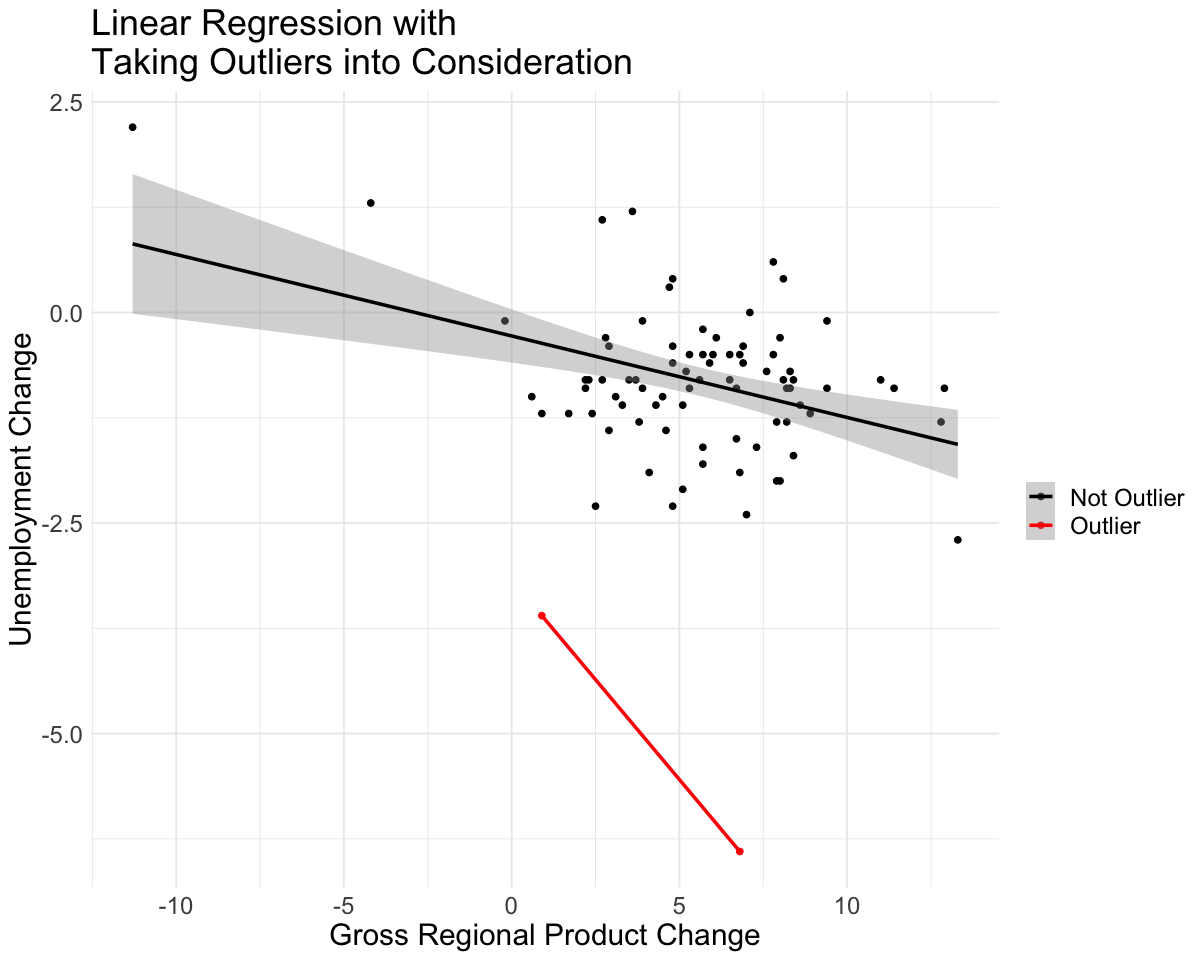

In [32]:
ggplot(df, aes(GRP_Change, Unemployment_Change, color=f.Is_Outlier)) +
    geom_point() +
    scale_color_manual(values = c("Not Outlier" = "black", "Outlier" = "red")) +
    stat_smooth(aes(GRP_Change, Unemployment_Change), method = "lm", formula = y ~ x) + 
    labs(
    x = "Gross Regional Product Change",
    y = "Unemployment Change",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Linear Regression with \nTaking Outliers into Consideration") + 
    theme(text = element_text(size=18))

## Часть 2

### 1. Введение дополнительных переменных

 Создадим дополнительные переменные:

In [33]:
df$lnUnemployment <- log(df$Unemployment)
df$lnGRP_per_capita <- log(df$GRP_per_capita)
df$lnUrban_Share <- log(df$Urban_Share)
df$lnHigher_Education <- log(df$Higher_Education)

Найдем дискриптивные статистики:

In [34]:
library("pastecs")


Attaching package: ‘pastecs’


The following objects are masked from ‘package:dplyr’:

    first, last


The following object is masked from ‘package:tidyr’:

    extract




In [35]:
stat.desc(df)

,Regions,Unemployment,GRP_per_capita,Urban_Share,Higher_Education,West,GRP_Change,Unemployment_Change,f.West,Is_Outlier,f.Is_Outlier,lnUnemployment,lnGRP_per_capita,lnUrban_Share,lnHigher_Education
,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
nbr.val,NA,83.0000000,8.300000e+01,83.0000000,83.0000000,83.00000000,83.0000000,83.0000000,NA,83.00000000,NA,83.00000000,8.300000e+01,83.00000000,83.00000000
nbr.null,NA,0.0000000,0.000000e+00,0.0000000,0.0000000,27.00000000,0.0000000,1.0000000,NA,81.00000000,NA,0.00000000,0.000000e+00,0.00000000,0.00000000
nbr.na,NA,0.0000000,0.000000e+00,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,NA,0.00000000,NA,0.00000000,0.000000e+00,0.00000000,0.00000000
min,NA,1.4000000,4.314612e+04,28.7000000,12.5000000,0.00000000,-11.3000000,-6.4000000,NA,0.00000000,NA,0.33647224,1.067235e+01,3.35689712,2.52572864
max,NA,48.8000000,2.415795e+06,100.0000000,47.6000000,1.00000000,13.3000000,2.2000000,NA,1.00000000,NA,3.88773031,1.469754e+01,4.60517019,3.86283276
range,NA,47.4000000,2.372649e+06,71.3000000,35.1000000,1.00000000,24.6000000,8.6000000,NA,1.00000000,NA,3.55125808,4.025192e+00,1.24827306,1.33710412
sum,NA,677.9000000,2.384720e+07,5786.0000000,2243.1000000,56.00000000,457.3000000,-76.1000000,NA,2.00000000,NA,163.68158437,1.024948e+03,350.52895480,272.17922792
median,NA,7.0000000,2.213870e+05,70.6000000,26.2000000,1.00000000,5.7000000,-0.9000000,NA,0.00000000,NA,1.94591015,1.230767e+01,4.25703014,3.26575941
mean,NA,8.1674699,2.873157e+05,69.7108434,27.0253012,0.67469880,5.5096386,-0.9168675,NA,0.02409639,NA,1.97206728,1.234877e+01,4.22324042,3.27926781


Построим диаграммы рассеяния

1)

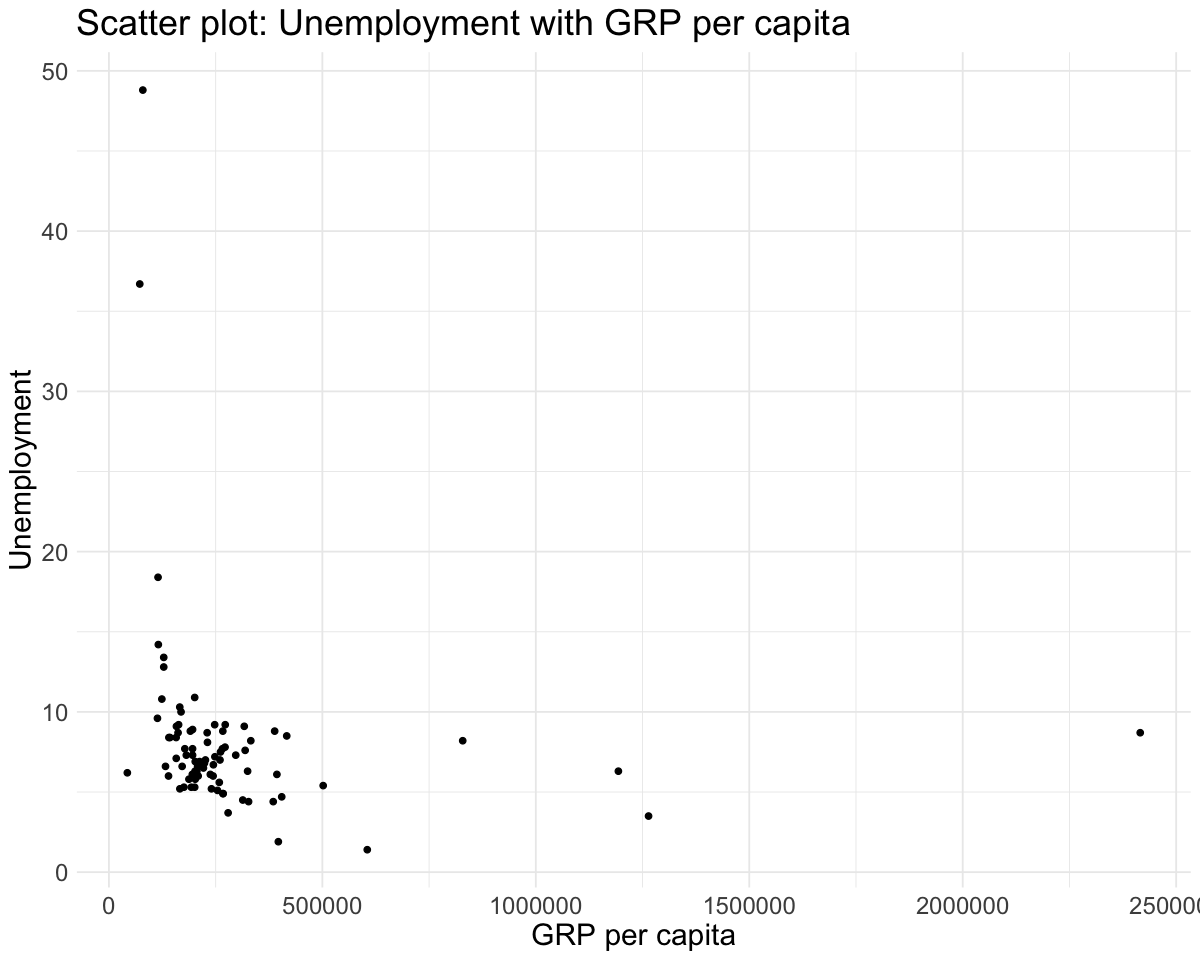

In [36]:
ggplot(df, aes(GRP_per_capita, Unemployment)) +
    geom_point() + 
    labs(
    x = "GRP per capita",
    y = "Unemployment",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: Unemployment with GRP per capita") + 
    theme(text = element_text(size=18))

2)

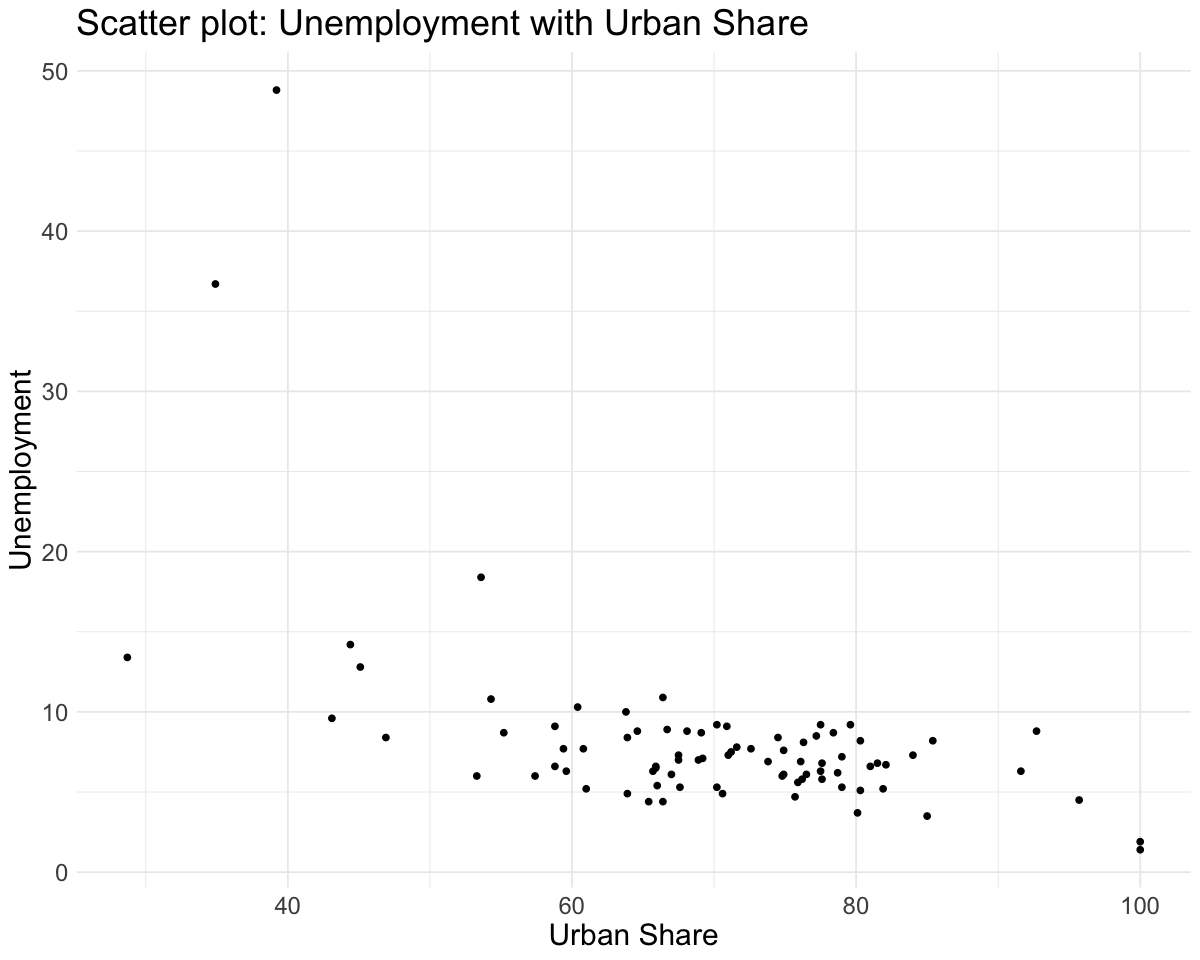

In [37]:
ggplot(df, aes(Urban_Share, Unemployment)) +
    geom_point() + 
    labs(
    x = "Urban Share",
    y = "Unemployment",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: Unemployment with Urban Share") + 
    theme(text = element_text(size=18))

3) 

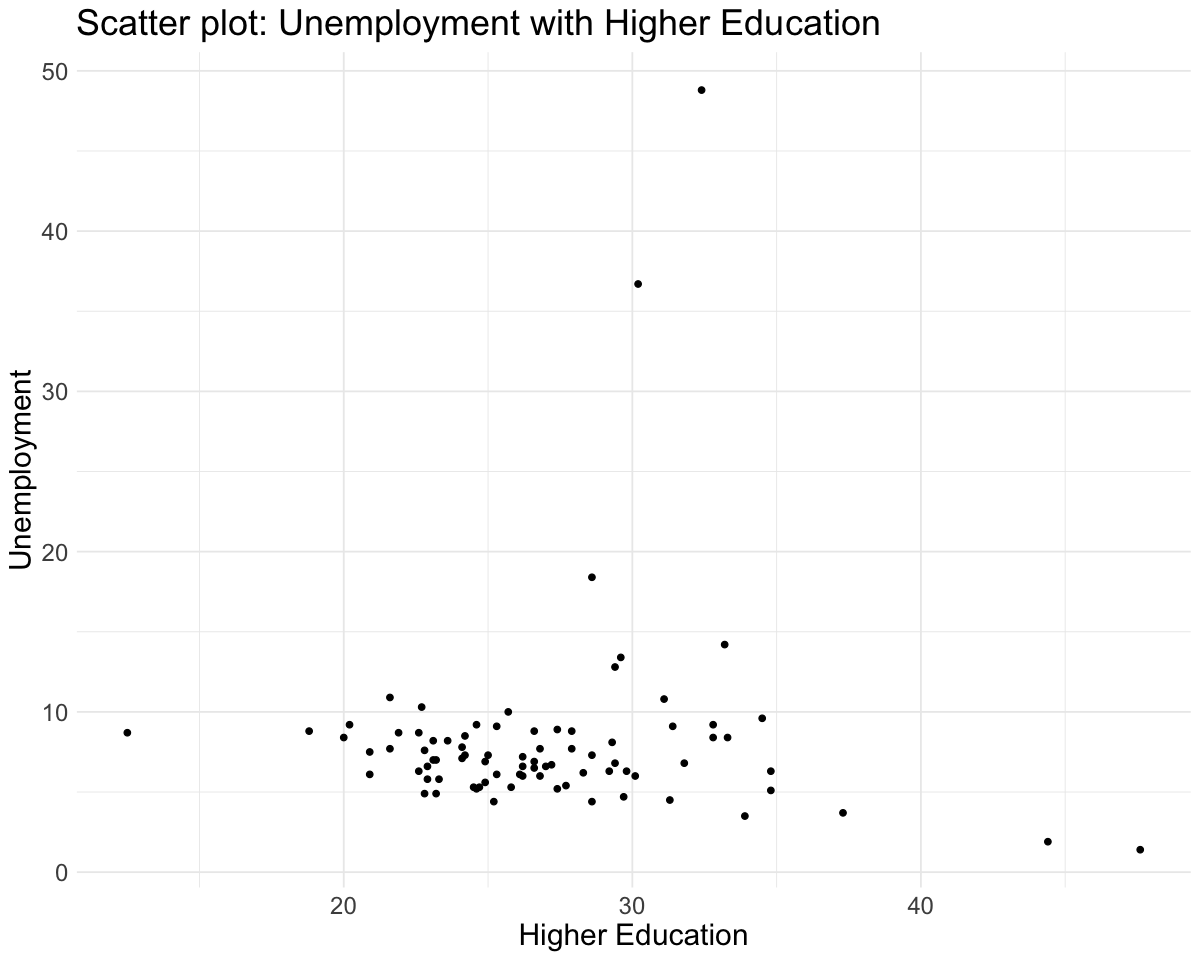

In [38]:
ggplot(df, aes(Higher_Education, Unemployment)) +
    geom_point() + 
    labs(
    x = "Higher Education",
    y = "Unemployment",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: Unemployment with Higher Education") + 
    theme(text = element_text(size=18))

4)

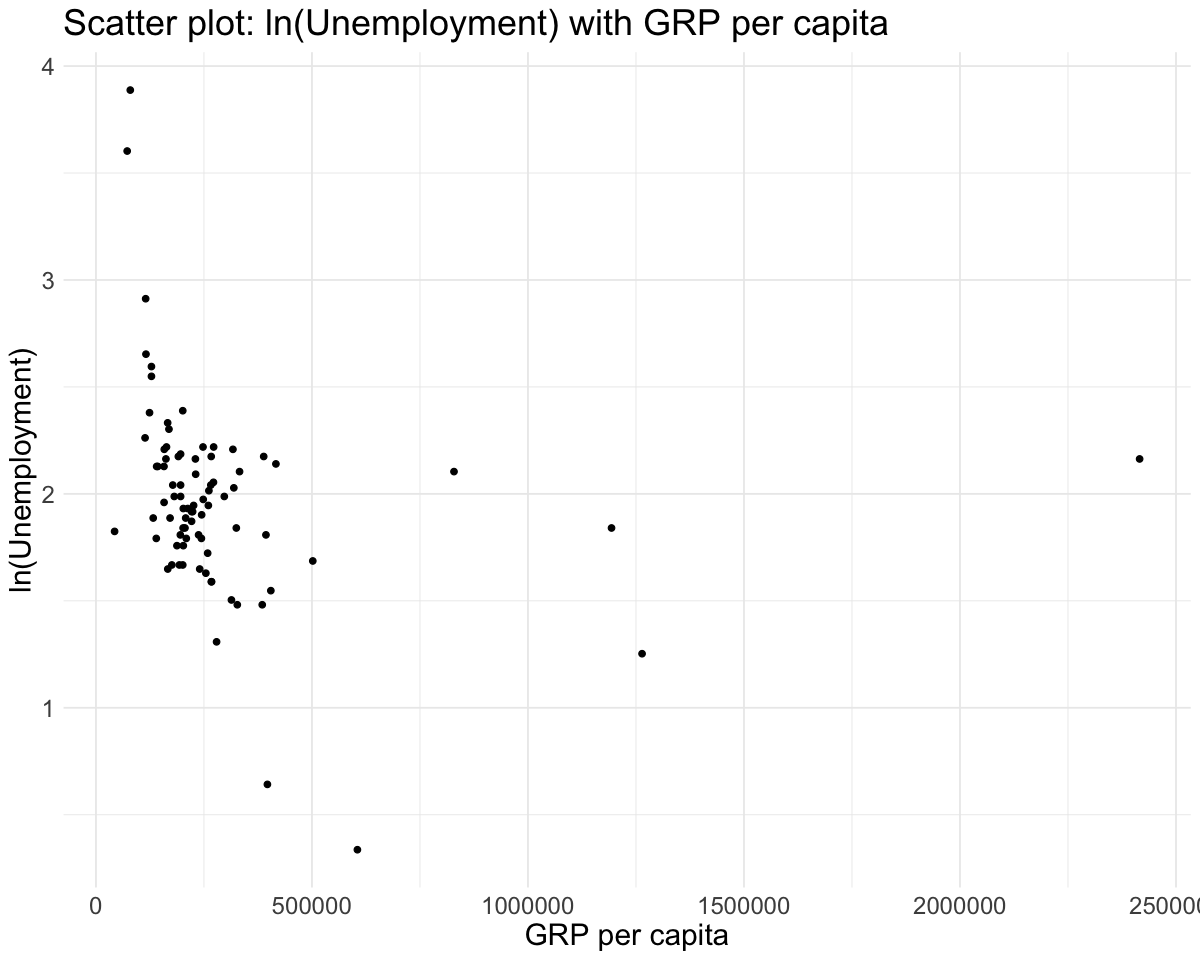

In [39]:
ggplot(df, aes(GRP_per_capita, lnUnemployment)) +
    geom_point() + 
    labs(
    x = "GRP per capita",
    y = "ln(Unemployment)",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: ln(Unemployment) with GRP per capita") + 
    theme(text = element_text(size=18))

5)

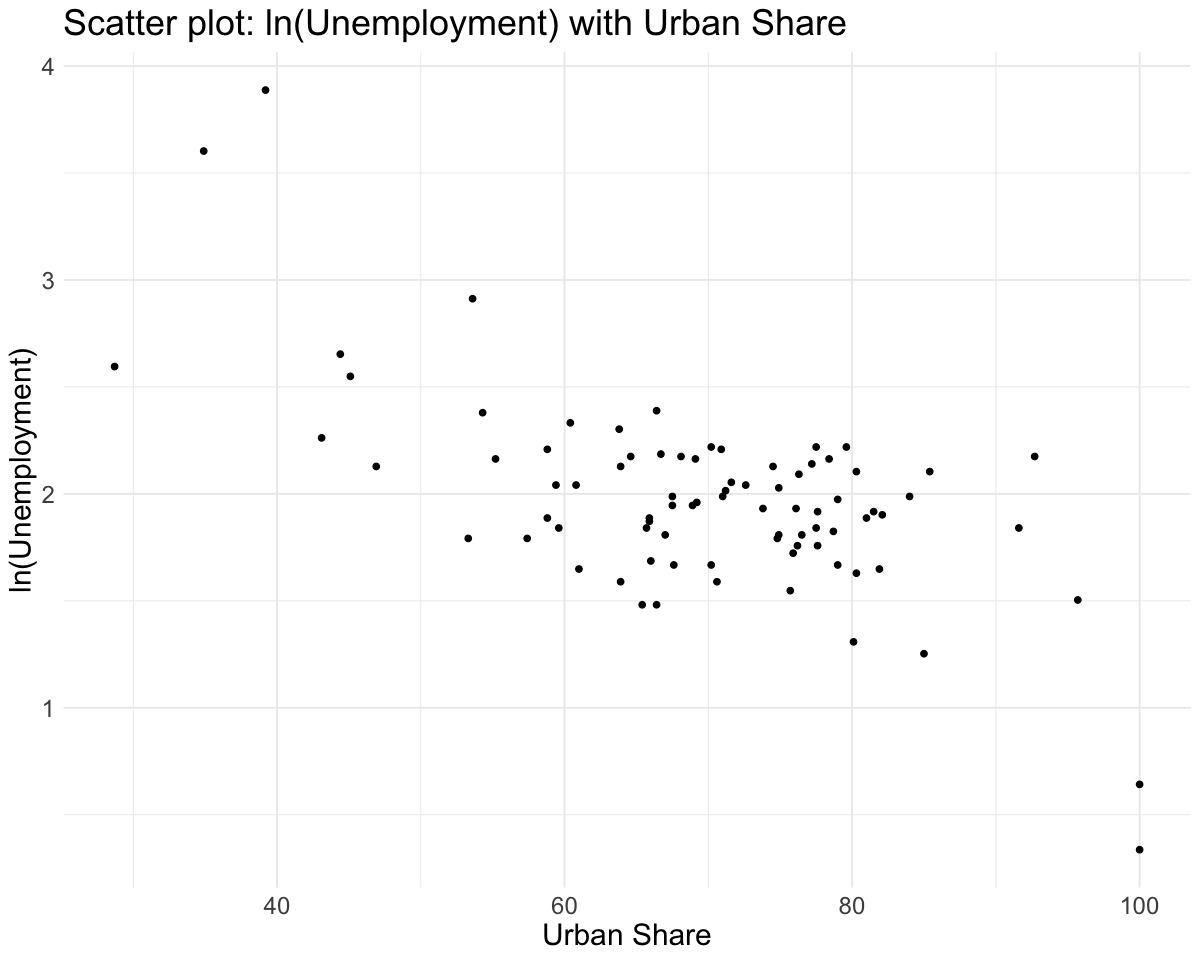

In [40]:
ggplot(df, aes(Urban_Share, lnUnemployment)) +
    geom_point() + 
    labs(
    x = "Urban Share",
    y = "ln(Unemployment)",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: ln(Unemployment) with Urban Share") + 
    theme(text = element_text(size=18))

6)

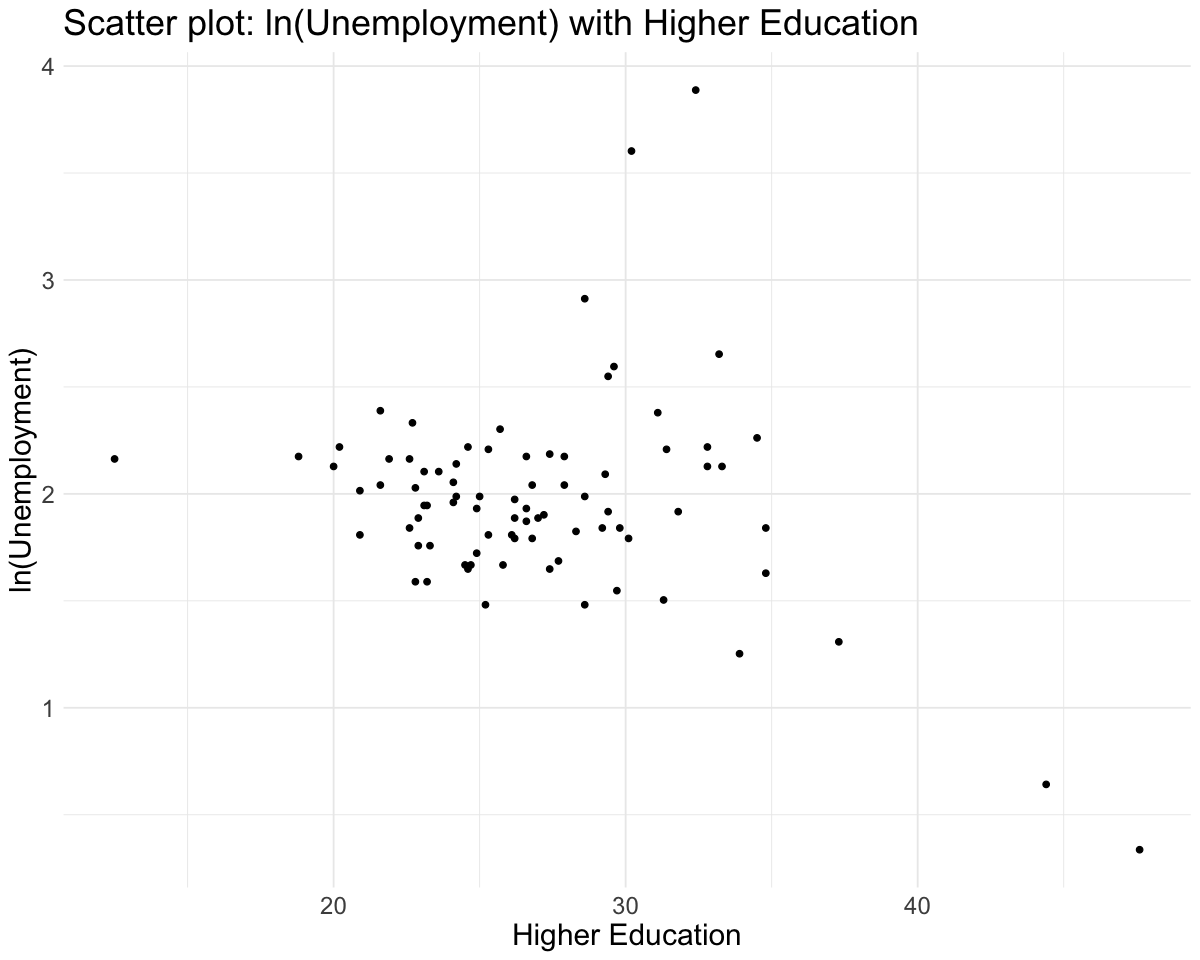

In [41]:
ggplot(df, aes(Higher_Education, lnUnemployment)) +
    geom_point() + 
    labs(
    x = "Higher Education",
    y = "ln(Unemployment)",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: ln(Unemployment) with Higher Education") + 
    theme(text = element_text(size=18))

7)

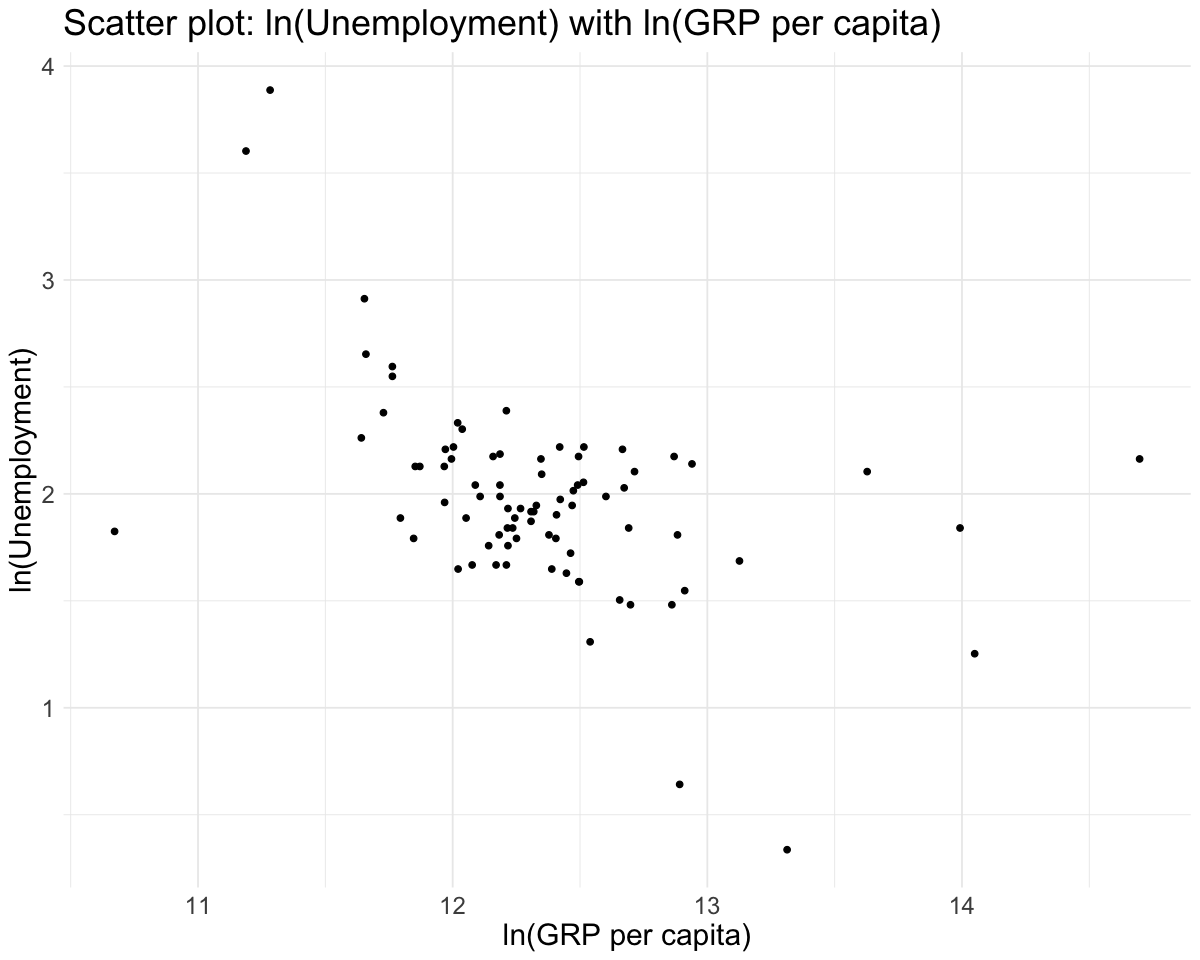

In [42]:
ggplot(df, aes(lnGRP_per_capita, lnUnemployment)) +
    geom_point() + 
    labs(
    x = "ln(GRP per capita)",
    y = "ln(Unemployment)",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: ln(Unemployment) with ln(GRP per capita)") + 
    theme(text = element_text(size=18))

8)

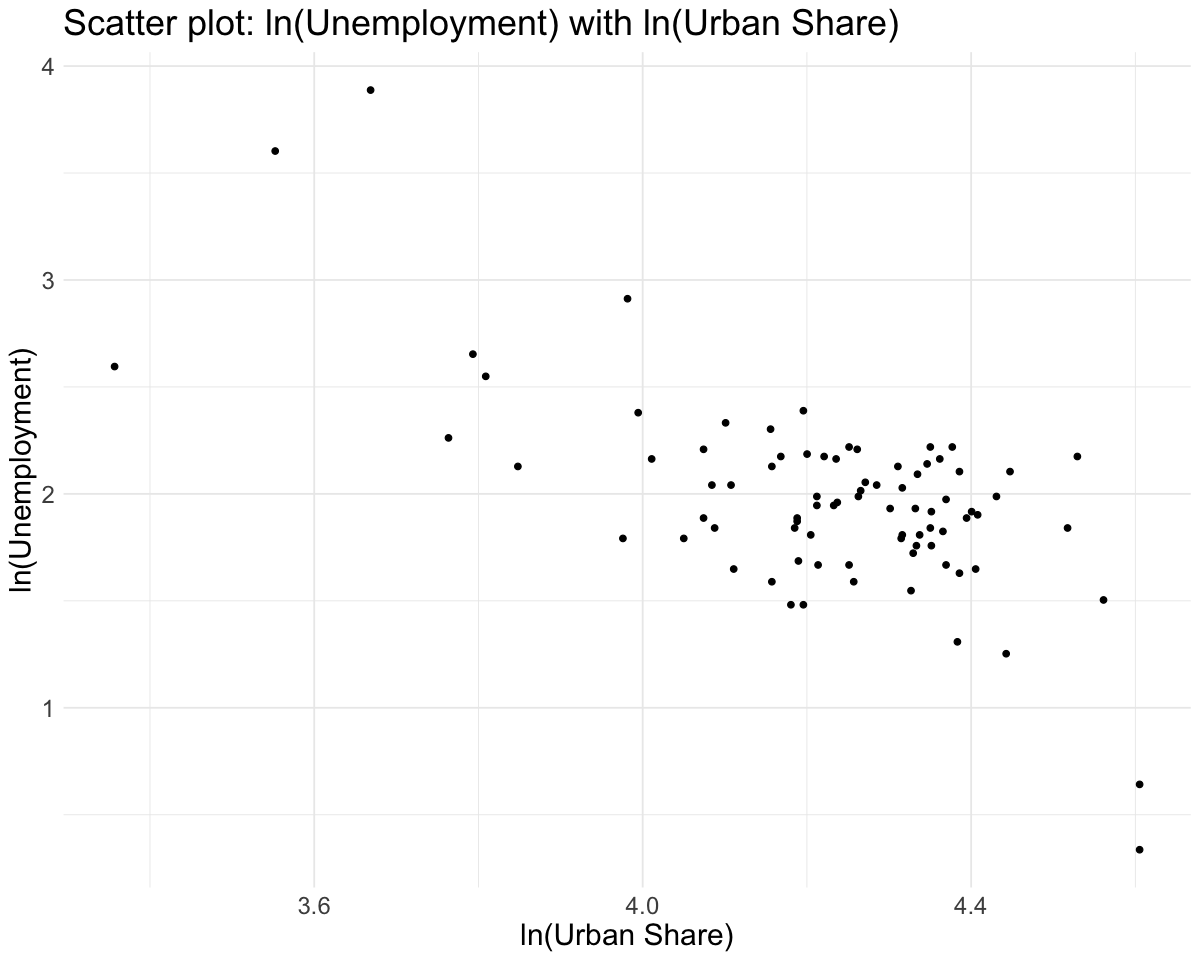

In [43]:
ggplot(df, aes(lnUrban_Share, lnUnemployment)) +
    geom_point() + 
    labs(
    x = "ln(Urban Share)",
    y = "ln(Unemployment)",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: ln(Unemployment) with ln(Urban Share)") + 
    theme(text = element_text(size=18))

9)

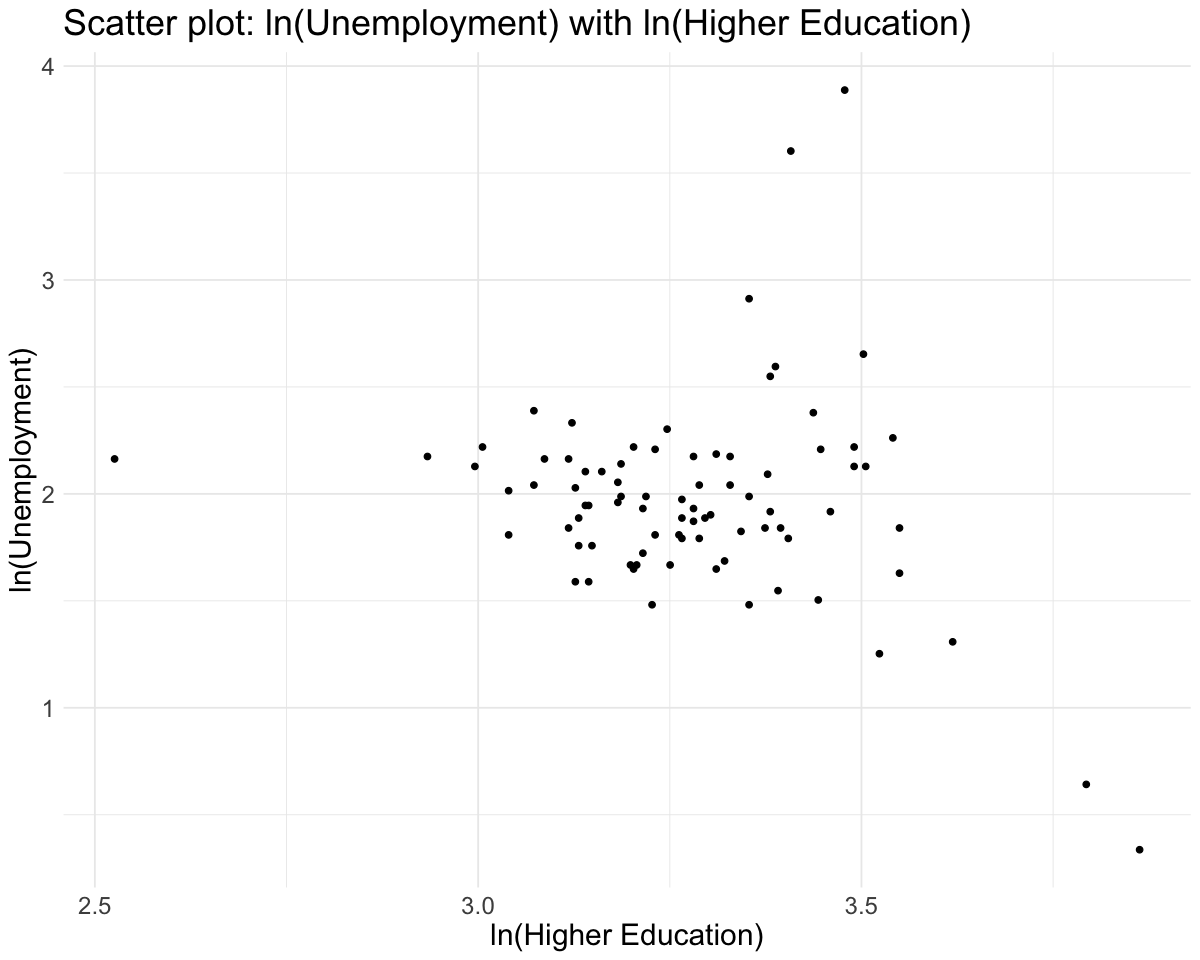

In [44]:
ggplot(df, aes(lnHigher_Education, lnUnemployment)) +
    geom_point() + 
    labs(
    x = "ln(Higher Education)",
    y = "ln(Unemployment)",
    color = ""
    ) +
    theme_minimal() + 
    ggtitle("Scatter plot: ln(Unemployment) with ln(Higher Education)") + 
    theme(text = element_text(size=18))

Заметим, что следующие зависимости больше всего похожи на линейную:
* `lnUnemployment` от `Urban_Share`
* `lnUnemployment` от `lnUrbanshare`

В дальнейшем нам придется выбрать между `Urban_Share` и `lnUrbanshare`.

### 2. Построение различных множественных регрессий

Оценим разные спецификации линейной регрессии, где зависимой переменной будет безработица, а независимыми переменными: 
ВРП на душу населения, доля городского населения и доля занятого населения, имеющего высшее образование.

#### Линейная регрессия:

$$
\text{Unemployment}_i = \beta_0 + \beta_1 \text{GRP_per_capita}_i + \beta_2 \text{Urban_Share}_i + \beta_3 \text{Higher_Education}_i + \varepsilon_i
$$

In [45]:
lr <- lm(Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education, data = df)
summary(lr)


Call:
lm(formula = Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education, 
    data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-6.381 -2.492 -0.254  1.342 32.063 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.344e+01  3.987e+00   5.878 9.43e-08 ***
GRP_per_capita    2.369e-07  1.962e-06   0.121    0.904    
Urban_Share      -2.630e-01  4.454e-02  -5.905 8.44e-08 ***
Higher_Education  1.108e-01  1.105e-01   1.003    0.319    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.094 on 79 degrees of freedom
Multiple R-squared:  0.3255,	Adjusted R-squared:  0.2999 
F-statistic: 12.71 on 3 and 79 DF,  p-value: 7.359e-07


Как видим, статистически значимы только свобоный коэффициент $\beta_0$ и регрессор переменной `Urban_Share` $\beta_2$ при любом разумном уровне значимости:
$$ 
\widehat{\text{Unemployment}}_i = \hat{\beta}_0 + \hat{\beta}_2 \text{Urban_Share}_i \approx 23.44 - 0.263 \times \text{Urban_Share}_i
$$

$R^2_{adj}$ показывает нам, что качество подгонки нашей модели составляет примерно $30\%$. Также наша линейная регрессия является адекватной при любом разумном уровне значимости.

#### Полулогарифмическая регрессия

$$
\ln\text{Unemployment}_i = \beta_0 + \beta_1 \text{GRP_per_capita}_i + \beta_2 \text{Urban_Share}_i + \beta_3 \text{Higher_Education}_i + \varepsilon_i
$$

In [46]:
semi_ln_lr <- lm(lnUnemployment ~ GRP_per_capita + Urban_Share + Higher_Education, data = df)
summary(semi_ln_lr)


Call:
lm(formula = lnUnemployment ~ GRP_per_capita + Urban_Share + 
    Higher_Education, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61172 -0.20302 -0.00089  0.16718  1.33693 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.975e+00  2.682e-01  14.817  < 2e-16 ***
GRP_per_capita   -9.224e-08  1.320e-07  -0.699   0.4866    
Urban_Share      -2.147e-02  2.996e-03  -7.164 3.62e-10 ***
Higher_Education -1.775e-02  7.432e-03  -2.388   0.0193 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3427 on 79 degrees of freedom
Multiple R-squared:  0.4711,	Adjusted R-squared:  0.451 
F-statistic: 23.46 on 3 and 79 DF,  p-value: 5.882e-11


Также как и в обычной множественной линейной регрессии статистически значимы свобоный коэффициент $\beta_0$ и регрессор переменной `Urban_Share` $\beta_2$, однако теперь статически значим еще и регрессор переменной `Higher_Education` $\beta_3$:

$$
\widehat{\ln\text{Unemployment}}_i = \hat{\beta}_0 + \hat{\beta}_2 \text{Urban_Share}_i + \hat{\beta}_3 \text{Higher_Education}_i \approx 3.975 -0.022 \times \text{Urban_Share}_i - 0.018 \times \text{Higher_Education}_i
$$

Заметим, полулогарифмическая регрессия намного лучше относительно обычной множественной линейной регрессии: качество подгонки модели увеличилось приблизительно на $50\%$, достигнув $R^2_{adj} \approx 0.45$. Однако, мы не можем сравнивать по $R^2_{adj}$ те модели, у которых не одинаковые зависимые переменные, так что далее в пункте 3 будем производить тесты по правильной спецификации модели.

Очевидно, что наша полулогарифмическая регрессия адекватна при любом разумном уровне значимости.

#### Линейная регрессия в логарифмах

$$
\ln\text{Unemployment}_i = \beta_0 + \beta_1 \ln\text{GRP_per_capita}_i + \beta_2 \ln\text{Urban_Share}_i + \beta_3 \ln\text{Higher_Education}_i + \varepsilon_i
$$

In [47]:
ln_lr <- lm(lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + lnHigher_Education, data = df)
summary(ln_lr)


Call:
lm(formula = lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + 
    lnHigher_Education, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66161 -0.19848 -0.01056  0.17445  1.19245 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         11.1239     1.1175   9.954 1.35e-15 ***
lnGRP_per_capita    -0.1771     0.0735  -2.409  0.01831 *  
lnUrban_Share       -1.1804     0.1942  -6.078 4.06e-08 ***
lnHigher_Education  -0.6038     0.1938  -3.115  0.00256 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3263 on 79 degrees of freedom
Multiple R-squared:  0.5205,	Adjusted R-squared:  0.5023 
F-statistic: 28.59 on 3 and 79 DF,  p-value: 1.285e-12


Как видим, свобоный коэффициент $\beta_0$ и все регрессоры $\{\beta_j\}_{j = 1}^3$ статистически значимы:

$$
\widehat{\ln\text{Unemployment}}_i \approx 11.12 - 0.177 \times \ln\text{GRP_per_capita}_i - 1.18 \times  \ln\text{Urban_Share}_i -0.6 \times  \ln\text{Higher_Education}_i 
$$

Поскольку у полулогарифмической и логарифмической регрессий одинаковые зависимые переменные, мы можем сравнить их по $R^2_{adj}$: качество подгонки логарифмической модели на $11\%$ выше.

Логарифмическая регрессия адекватна при любом разумном уровне значимости.

#### Заключение

Выведем все модели в одну таблицу:

In [48]:
table <- mtable(lr, semi_ln_lr, ln_lr)
print(table)


Calls:
lr: lm(formula = Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education, 
    data = df)
semi_ln_lr: lm(formula = lnUnemployment ~ GRP_per_capita + Urban_Share + 
    Higher_Education, data = df)
ln_lr: lm(formula = lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + 
    lnHigher_Education, data = df)

                           lr         semi_ln_lr        ln_lr       
                     ------------- --------------- ---------------   
                      Unemployment  lnUnemployment  lnUnemployment  
--------------------------------------------------------------------
  (Intercept)          23.436***       3.975***       11.124***     
                       (3.987)        (0.268)         (1.118)       
  GRP_per_capita        0.000         -0.000                        
                       (0.000)        (0.000)                       
  Urban_Share          -0.263***      -0.021***                     
                       (0.045)        (0.003)            

### 3. Выбор функциональной формы модели

Попытаемся ответить на вопрос, какая из моделей является предпочтительной.

Как уже отмечалось выше, у полулогарифмической и логарифмической регрессий одинаковые зависимые переменные. Следовательно, мы можем сравнить их по $𝑅^2_{𝑎𝑑𝑗}$: качество подгонки логарифмической модели выше, нежели полулогарифмической. 

Теперь нам нужно сравнить обычную линейную регрессию и логарифмическую регрессию посредством следующих тестов:
* Бокса-Кокса
* Зарембки
* PE-теста МакКиннона, Уайта и Дэвидсона

#### Тест Бокса-Кокса

a) Тестируем следующую функциональную форму:
$
y^{(\lambda)} = \beta_0 + \beta_1x_1^{(\lambda)} + \beta_2 x_2^{(\lambda)} + \beta_3x_3^{(\lambda)} + \varepsilon
$

$
y^{(\lambda)} 
=\begin{cases} \dfrac{y^\lambda - 1}{\lambda}, & \mbox{if } \lambda \neq 0 \\ \ln y, & \mbox{if } \lambda = 0 \end{cases}
$

$
x^{(\lambda)} 
=\begin{cases} \dfrac{x^\lambda - 1}{\lambda}, & \mbox{if } \lambda \neq 0 \\ \ln x, & \mbox{if } \lambda = 0 \end{cases}
$

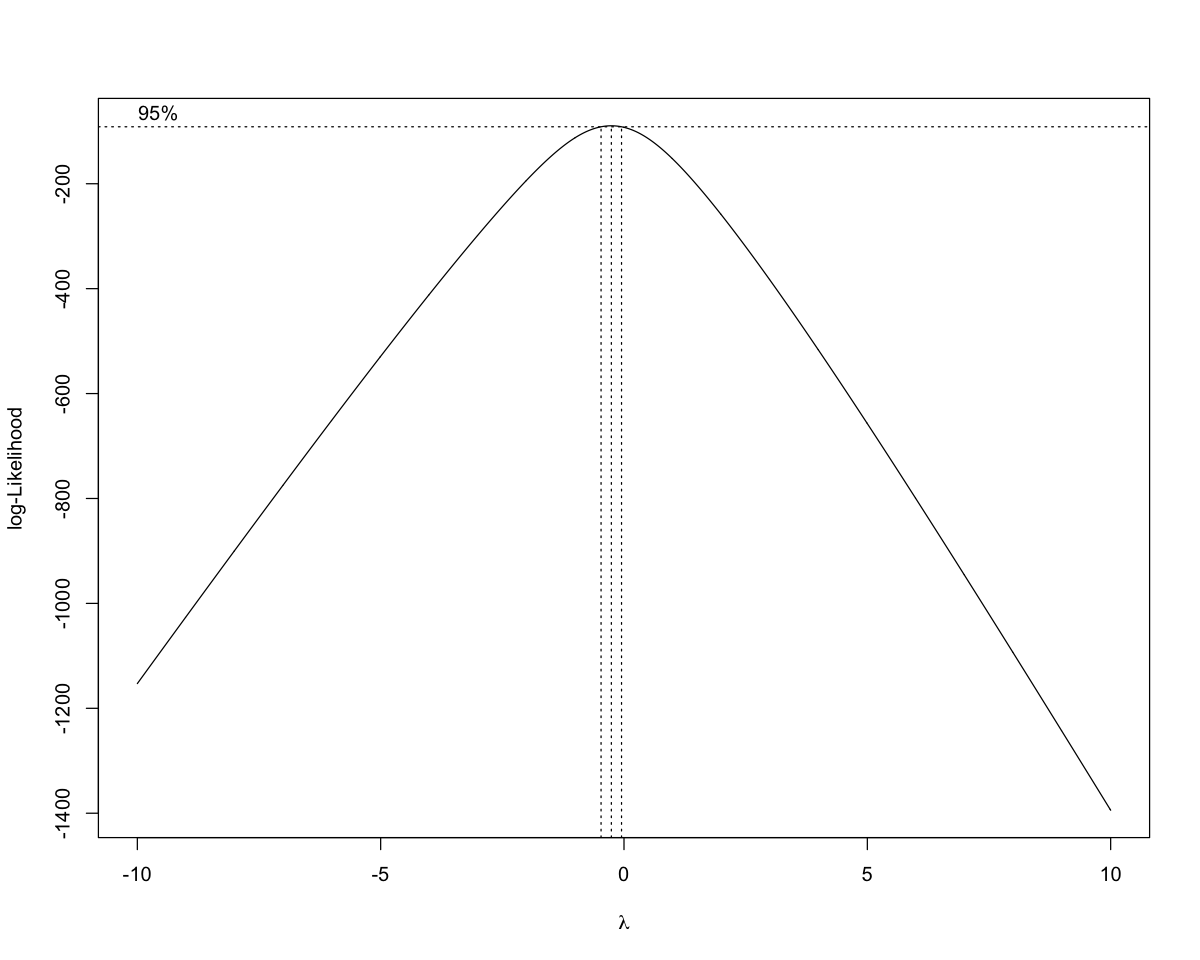

In [49]:
boxcox(Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education, data=df, lambda=seq(-10, 10, 0.01), plotit=TRUE)

Видим, что максимум правдоподобия достигается в значениях достаточно близких к $\lambda = 0$. Следовательно, логарифмическая регрессия лучше описывает наши данные, нежели обычная множественная регрессия.

#### Тест Зарембки

Будем использовать частный случай теста Бокса-Кокса, а именно тест Зарембки. 

Модель 1 (`lr`) в векторном представлении:

$
y = \beta_0 + \beta_1x_1 + \beta_2 x_2 + \beta_3x_3 + \varepsilon
$

Модель 2 (`ln_lr`) в векторном представлении:

$
\ln y = \beta_0 + \beta_1\ln x_1 + \beta_2 \ln x_2 + \beta_3 \ln x_3 + \varepsilon
$

$
\begin{cases}
H_0: \text{Качество подгонки моделей 1 и 2 одинаковое} \\
H_a: \text{Модель с меньшей RSS лучше}
\end{cases}
$

1) Вычисляем геометрическое среднее зависимой переменной:

$
\bar Y =\displaystyle \sqrt[n]{\prod\limits ^{n}_{i=1} Y_{i}} = \exp\left(\dfrac{1}{n}\sum ^{n}_{i=1}\ln Y_{i}\right)
$

In [50]:
bar_Unemployment <- prod(df$Unemployment)^(1/ nrow(df))

2) Вводим вспомогательные модели:

$\displaystyle \widetilde{Y_{i}} =\dfrac{Y_{i}}{\overline{Y}}$

Модель 3 в векторном представлении:

$\displaystyle \tilde{y} =\beta ^{'}_{0} +\beta ^{'}_{1} x_{1} +\beta ^{'}_{2} x_{2} +\beta ^{'}_{3} x_{3} +\varepsilon $

Модель 4 в векторном представлении:

$\displaystyle \ln\tilde{y} =\beta ^{'}_{0} +\beta ^{'}_{1} \ln x_{1} +\beta ^{'}_{2} \ln x_{2} +\beta ^{'}_{3} \ln x_{3} +\varepsilon $

In [51]:
tilda_Unemployment <- df$Unemployment / bar_Unemployment
ln_tilda_Unemployment <- log(tilda_Unemployment)

In [52]:
model_3 <- lm(tilda_Unemployment ~ df$GRP_per_capita + df$Urban_Share + df$Higher_Education)
model_4 <- lm(ln_tilda_Unemployment ~ df$lnGRP_per_capita + df$lnUrban_Share + df$lnHigher_Education)

3) Считаем тестовую статистику:

$ \chi ^{2}_{obs} =\frac{n}{2} \left|\ln\dfrac{RSS_{3}}{RSS_{4}} \right| \stackrel{H_0}{\sim} \chi ^{2}( 1)$

In [53]:
RSS_3 <- sum(residuals(model_3)^2)
RSS_4 <- sum(residuals(model_4)^2)

In [54]:
chi_squared_obs = (nrow(df)/2) *  abs(log(RSS_3 / RSS_4))
chi_squared_obs

[1] 64.39252

In [55]:
alpha <- c(0.1, 0.075, 0.05, 0.025, 0.01) 
qchisq(1 - alpha, df=1)

[1] 2.705543 3.170053 3.841459 5.023886 6.634897

Как видим, $ \chi ^{2}_{obs} > \chi_{1 - \alpha}^{2}(1)$ при любом разумном уровне значимости. Значит, нулевая гипотеза о том, что модель 1 и модель 2 не имеют статистически значимых различий, отвергается при любом разумном уровне значимости. Выбирается модель с наименьшим RSS.

In [56]:
RSS_3

[1] 39.70106

In [57]:
RSS_4

[1] 8.412772

Следовательно, предпочтительнее логарифмическая модель, нежели обычная регрессия. 

#### PE-тест МакКиннона, Уайта и Дэвидсона

$
\begin{cases}
H_0: y = \beta_0 + \beta_1x_1 + \beta_2 x_2 + \beta_3x_3 + \varepsilon \\
H_a: \ln y = \beta_0 + \beta_1\ln x_1 + \beta_2 \ln x_2 + \beta_3 \ln x_3 + \varepsilon
\end{cases}
$

Оценим вспомогательные регрессии:

Модель 1

$y = \beta_0 + \beta_1x_1 + \beta_2 x_2 + \beta_3x_3 + \theta_1 [\widehat{\ln y} - \ln \hat{y}] + \varepsilon$

Модель 2

$\ln y = \beta_0 + \beta_1\ln x_1 + \beta_2 \ln x_2 + \beta_3 \ln x_3 + \theta_2 [\hat{y} - \exp(\widehat{ln y})] + \varepsilon$



In [58]:
output <- petest(lr, ln_lr)
print(output)

PE test

Model 1: Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education
Model 2: lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + lnHigher_Education
                          Estimate Std. Error t value  Pr(>|t|)    
M1 + log(fit(M1))-fit(M2) -11.5218    2.79122 -4.1279 9.101e-05 ***
M2 + fit(M1)-exp(fit(M2))  -0.0409    0.03084 -1.3249    0.1891    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


PE-тест показывает, что логарифмическая спецификация также лучше описывает данные, поскольку коэффициент $\theta_1$ статистически значим, то есть добавление логарифмической зависимости в линейную модель статистически значимо, а коэффициент $\theta_2$ — нет.

#### Итог

В качестве наиболее предпочтительной модели выбираем логарифмическую регрессию по нескольким причинам:

1) Тест Бокса-Кокса является _наиболее общим_ тестом, и он явно показывает, что максимум правдоподобия достигается не при линейной спецификации модели ($\lambda = 1$), а при логарифмической. Следовательно, и тест Зарембки, как частный случай, демонстрирует тот же результат.

2) PE-тест демонстрирует, что логарифмическая модель лучше.

3) В экономических моделях принято брать логарифм от ВВП/ВРП, нежели сам ВВП/ВРП.

### 4. Добавление переменной `WEST ` в лучшую модель 

Оценим наилучшую модель, добавив в нее дамми переменную:

$
\ln\text{Unemployment}_i = \beta_0 + \beta_1 \ln\text{GRP_per_capita}_i + \beta_2 \ln\text{Urban_Share}_i + \beta_3 \ln\text{Higher_Education}_i +  \beta_4\text{West}_i + \varepsilon_i
$

In [59]:
best <- lm(lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + lnHigher_Education + West, data=df)
summary(best)


Call:
lm(formula = lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + 
    lnHigher_Education + West, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59605 -0.18247 -0.02079  0.17631  1.22588 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        11.65803    1.09680  10.629  < 2e-16 ***
lnGRP_per_capita   -0.20023    0.07144  -2.803  0.00639 ** 
lnUrban_Share      -1.19627    0.18742  -6.383 1.15e-08 ***
lnHigher_Education -0.61858    0.18705  -3.307  0.00143 ** 
West               -0.19672    0.07478  -2.631  0.01026 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3147 on 78 degrees of freedom
Multiple R-squared:  0.5596,	Adjusted R-squared:  0.537 
F-statistic: 24.78 on 4 and 78 DF,  p-value: 2.945e-13


Как видим, все пременные статистически значимы. При добавлении дамми переменной качество подгонки лучшей регресси приблизительно увеличилось на $7\%$. Модель адекватна при любом разумном уровне значимости.

$$
\widehat{\ln\text{Unemployment}}_i \approx 11.66 - 0.2 \times \ln\text{GRP_per_capita}_i - 1.12 \times  \ln\text{Urban_Share}_i -0.62 \times \ln\text{Higher_Education}_i - 0.1967 \times \text{West}_i
$$

#### Интерпретация лучшей модели

Под увеличением доли на $\gamma$ процентов, будем подразумевать операцию $y \times (1 + \gamma)$, а увеличение доли на $\gamma$ процентных пунктов $y + \gamma$ (мы использовали это в первой части д/з), где $y$ — это доля. К примеру, под увеличением исходного уровня безработицы в размере $6\%$ на $1\%$ будем понимать $0.06 \times 1.01 \approx 0.061$, а не $0.06 + 0.01 = 0.07$.

__*Ceteris paribus*__, можно выделить следующие зависимости: 
* Безработица в западных регионах меньше на $19.67\%$.

* При увеличении валового регионального продукта на $1\%$, уровень безработицы уменьшается на $0.2\%$.

* При увеличении доли городского населения на $1\%$ , уровень безработицы уменьшается на  $1.2\%$.

* При увеличении занятого населения, имеющего высшее образование, на $1\%$, уровень безработицы уменьшается на  $0.62\%$.

## Часть 3

### 1. Правильная спецификация модели

Проверим линейную модель на правильную спецификацию:

$$
\text{Unemployment}_i = \beta_0 + \beta_1 \text{GRP_per_capita}_i + \beta_2 \text{Urban_Share}_i + \beta_3 \text{Higher_Education}_i + \varepsilon_i
$$

$
\begin{cases}
H_0: \text{спецификация модели является правильной} \\
H_a: \text{спецификация модели является неправильной}
\end{cases}
$ 

Воспользуемся тестом Рамсея.

1) Оценим коэффициенты нашей регрессии ($\text{R}$):

In [60]:
lr <- lm(Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education, data=df)
summary(lr)


Call:
lm(formula = Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education, 
    data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-6.381 -2.492 -0.254  1.342 32.063 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.344e+01  3.987e+00   5.878 9.43e-08 ***
GRP_per_capita    2.369e-07  1.962e-06   0.121    0.904    
Urban_Share      -2.630e-01  4.454e-02  -5.905 8.44e-08 ***
Higher_Education  1.108e-01  1.105e-01   1.003    0.319    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.094 on 79 degrees of freedom
Multiple R-squared:  0.3255,	Adjusted R-squared:  0.2999 
F-statistic: 12.71 on 3 and 79 DF,  p-value: 7.359e-07


Только свободный коэффициент и регрессор `Urban_Share` являются статистически значимыми при любом разумном уровне значимости.
Качество подгонки регресии по $R^2_{adj}$ составило приблизительно $30 \%$. Данная модель адекватна при любом разумном уровне значимости.

2) Оценим коэффициенты вспомогательной регрессии ($\text{UR}$):

$
\ln\text{Unemployment}_i = \beta_0 + \beta_1 \text{GRP_per_capita}_i + \beta_2 \text{Urban_Share}_i + \beta_3  \text{Higher_Education}_i +  \beta_4\text{West}_i + \alpha_2 (\widehat{\text{Unemployment}}_i)^2 + \alpha_3(\widehat{\text{Unemployment}}_i)^3 + \varepsilon_i
$

$
\begin{cases}
H_0: \alpha_2 = \alpha_3 = 0 \\
H_a: \alpha^2_2 + \alpha^2_3 > 0
\end{cases}
$

Тестовая статистика имеет следующий вид:

$
F_{obs} = \dfrac{(\text{RSS}_R - \text{RSS}_{UR})/2}{\text{RSS}_{UR}/(86 - 7)} \stackrel{H_0}{\sim} F(2, 76)
$

In [61]:
resettest(lr, power=2:3, type="fitted", data=df)


	RESET test

data:  lr
RESET = 9.4906, df1 = 2, df2 = 77, p-value = 0.0002069


Нулевая гипотеза отвергается при любом разумном уровне значимости. Проверяя основную регрессию на пропуск квадратичной и кубической зависимости, тест Рамсея показывает, что модель неправильно специфицирована.

#### Решение проблемы
<br>1. Поробуем добавить в модель квадраты объясняющих переменных.

In [62]:
lr_1 <- lm(Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education + 
           I(GRP_per_capita^2) + I(Urban_Share^2) + I(Higher_Education^2), 
           data=df)
summary(lr_1)


Call:
lm(formula = Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education + 
    I(GRP_per_capita^2) + I(Urban_Share^2) + I(Higher_Education^2), 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.1282  -1.6005  -0.2634   1.0981  28.7524 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            5.143e+01  1.468e+01   3.503 0.000773 ***
GRP_per_capita        -9.396e-06  6.142e-06  -1.530 0.130240    
Urban_Share           -1.431e+00  2.991e-01  -4.785 8.23e-06 ***
Higher_Education       9.235e-01  7.331e-01   1.260 0.211613    
I(GRP_per_capita^2)    4.483e-12  2.825e-12   1.587 0.116728    
I(Urban_Share^2)       9.347e-03  2.297e-03   4.069 0.000114 ***
I(Higher_Education^2) -1.795e-02  1.220e-02  -1.471 0.145391    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.664 on 76 degrees of freedom
Multiple R-squared:  0.456,	Adjusted R-squared:  0.4131 
F-statisti

Заметим, что качество подгонки регрессии по $R^2_{adj}$ выросло примерно на $37.75\%$.

Проведем тест Рамсея.

In [63]:
resettest(lr_1, power=2:3, type="fitted", data=df)


	RESET test

data:  lr_1
RESET = 23.061, df1 = 2, df2 = 74, p-value = 1.643e-08


Нулевая гипотеза о правильной спецификации модели по прежнему отвергается.

<br> 2. Попробуем добавить кубы объясняющих переменных.

In [64]:
lr_2 <- lm(Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education + 
           I(GRP_per_capita^2) + I(Urban_Share^2) + I(Higher_Education^2) + 
           I(GRP_per_capita^3) + I(Urban_Share^3) + I(Higher_Education^3), 
           data=df)
summary(lr_2)


Call:
lm(formula = Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education + 
    I(GRP_per_capita^2) + I(Urban_Share^2) + I(Higher_Education^2) + 
    I(GRP_per_capita^3) + I(Urban_Share^3) + I(Higher_Education^3), 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.3580  -1.4913  -0.1988   1.1352  28.1709 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)  
(Intercept)            1.072e+02  5.642e+01   1.900   0.0614 .
GRP_per_capita        -2.169e-05  1.413e-05  -1.535   0.1291  
Urban_Share           -1.887e+00  1.310e+00  -1.441   0.1538  
Higher_Education      -3.558e+00  5.295e+00  -0.672   0.5037  
I(GRP_per_capita^2)    2.213e-11  1.660e-11   1.333   0.1866  
I(Urban_Share^2)       1.754e-02  2.124e-02   0.826   0.4116  
I(Higher_Education^2)  1.197e-01  1.706e-01   0.702   0.4851  
I(GRP_per_capita^3)   -6.073e-18  4.935e-18  -1.231   0.2224  
I(Urban_Share^3)      -4.499e-05  1.113e-04  -0.404   0.6872  
I(Higher_Ed

Все регрессоры являются статистически незначимыми.

In [65]:
resettest(lr_2, power=2:3, type="fitted", data=df)


	RESET test

data:  lr_2
RESET = 28.53, df1 = 2, df2 = 71, p-value = 8.065e-10


Очевидно, тест Рамсея отвергает нулевую гипотезу о правильной спецификации модели.

<br> 3. Попробуем добавить просто кубы без квадратов.

In [66]:
lr_3 <- lm(Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education +
           I(GRP_per_capita^3) + I(Urban_Share^3) + I(Higher_Education^3), 
           data=df)
summary(lr_3)


Call:
lm(formula = Unemployment ~ GRP_per_capita + Urban_Share + Higher_Education + 
    I(GRP_per_capita^3) + I(Urban_Share^3) + I(Higher_Education^3), 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.0967  -1.4323  -0.2252   1.2252  28.9242 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.430e+01  1.097e+01   4.038 0.000128 ***
GRP_per_capita        -5.068e-06  4.132e-06  -1.226 0.223799    
Urban_Share           -8.668e-01  1.635e-01  -5.300  1.1e-06 ***
Higher_Education       4.523e-01  3.795e-01   1.192 0.236979    
I(GRP_per_capita^3)    1.106e-18  8.213e-19   1.346 0.182202    
I(Urban_Share^3)       4.863e-05  1.215e-05   4.001 0.000145 ***
I(Higher_Education^3) -2.243e-04  1.319e-04  -1.701 0.093073 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.698 on 76 degrees of freedom
Multiple R-squared:  0.4482,	Adjusted R-squared:  0.4046 
F-statist

In [67]:
resettest(lr_3, power=2:3, type="fitted", data=df)


	RESET test

data:  lr_3
RESET = 16.436, df1 = 2, df2 = 74, p-value = 1.241e-06


Правильная спецификация модели также отвергается.

Можем констатировать, что добавление квадратов и кубов не имеет смысла для определения правильной спецификации модели. Также это не имеет и экономического смысла.


<br> 4. Вспомним диаграммы рассеяния из __части 2.1__. Похоже, логарифм от целевой переменной `Unemployment` линейно зависим от логарифма объсняющих переменных.



Тогда попробуем проверить нашу наилучшую модель из __части 2.4__ на правильную спецификацию:

$
\ln\text{Unemployment}_i = \beta_0 + \beta_1 \ln\text{GRP_per_capita}_i + \beta_2 \ln\text{Urban_Share}_i + \beta_3 \ln\text{Higher_Education}_i +  \beta_4\text{West}_i + \varepsilon_i
$

$
\begin{cases}
H_0: \text{спецификация модели является правильной} \\
H_a: \text{спецификация модели является неправильной}
\end{cases}
$ 

1) Оценим коэффициенты нашей регрессии:

In [68]:
best <- lm(lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + lnHigher_Education + West, data=df)
best


Call:
lm(formula = lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + 
    lnHigher_Education + West, data = df)

Coefficients:
       (Intercept)    lnGRP_per_capita       lnUrban_Share  lnHigher_Education  
           11.6580             -0.2002             -1.1963             -0.6186  
              West  
           -0.1967  


Получим:

$
\widehat{\ln\text{Unemployment}}_i \approx 11.66 - 0.2 \times \ln\text{GRP_per_capita}_i - 1.12 \times  \ln\text{Urban_Share}_i -0.62 \times \ln\text{Higher_Education}_i - 0.1967 \times \text{West}_i
$

2) Оценим коэффициенты вспомогательной регрессии:

In [69]:
resettest(best, power=2:3, type="fitted", data=df)


	RESET test

data:  best
RESET = 1.4129, df1 = 2, df2 = 76, p-value = 0.2498


Нулевая гипотеза не отвергается при любом разумном уровне значимости. Следовательно, проверяя основную регрессию на пропуск квадратичной и кубической зависимости, тест Рамсея показывает, что модель __правильно специфицирована__.

### 2. Проблема мультиколлинеарности

#### VIFы

$
\ln\text{Unemployment}_i = \beta_0 + \beta_1 \ln\text{GRP_per_capita}_i + \beta_2 \ln\text{Urban_Share}_i + \beta_3 \ln\text{Higher_Education}_i +  \beta_4\text{West}_i + \varepsilon_i
$

Проверим, есть ли у данной модели проблема мультиколлинеарности. По-иному, есть ли у данной модели линейная зависимость между объясняющими переменными.

Для этого введем вспомогательные регрессии:

$
\ln\text{GRP_per_capita}_i = \gamma_0 + \gamma_2 \ln\text{Urban_Share}_i + \gamma_3 \ln\text{Higher_Education}_i + \gamma_4\text{West}_i + \varepsilon_i
$

$
\ln\text{Urban_Share}_i = \gamma_0 + \gamma_1 \ln\text{GRP_per_capita}_i + \gamma_3 \ln\text{Higher_Education}_i + \gamma_4\text{West}_i + \varepsilon_i
$

$
\ln\text{Higher_Education}_i = \gamma_0 + \gamma_1 \ln\text{GRP_per_capita}_i + \gamma_2 \ln\text{Urban_Share}_i + \gamma_4\text{West}_i + \varepsilon_i
$

$
\text{West}_i = \gamma_0 + \gamma_1 \ln\text{GRP_per_capita}_i + \gamma_2 \ln\text{Urban_Share}_i + \gamma_3 \ln\text{Higher_Education}_i  + \varepsilon_i
$

Оценив их, рассчитаем для каждой регрессионной модели VIFы:

$
\text{VIF}_j = \dfrac{1}{1 - R^2_j}
$

где $R^2_j$ — это коэффициент $R^2$ в регрессии $j$-ой объясняющей переменной на остальные.

In [70]:
output <- vif(best)
print(output)

  lnGRP_per_capita      lnUrban_Share lnHigher_Education               West 
          1.418413           1.367954           1.028008           1.028189 


Проверим, правильно ли работает данная функция:

In [71]:
lr_1 <- lm(lnGRP_per_capita ~ lnUrban_Share + lnHigher_Education + West, data=df)
r_squared_1 <- summary(lr_1)$r.squared
vif_1 <- 1 / (1 - r_squared_1)
vif_1

[1] 1.418413

Как видим, все верно. 

Значит, по идее, у нас отсутствует мультиколлинеарность. Однако, не будем торопиться и проверим нашу регрессионную модель на наличие данной проблемы посредством других методов.

#### Корреляционная матрица 

Рассмотрим корриляционную матрицу регрессоров.

In [72]:
X <- model.matrix(~ 0 + lnGRP_per_capita + lnUrban_Share + lnHigher_Education, data=df)
head(X)

,lnGRP_per_capita,lnUrban_Share,lnHigher_Education
1,12.86073,4.195697,3.353407
2,11.96836,4.237001,3.182212
3,12.14136,4.351567,3.148453
4,12.24399,4.188138,3.295837
5,11.79471,4.394449,3.265759
6,12.46296,4.329417,3.214868


In [73]:
cor(X)

,lnGRP_per_capita,lnUrban_Share,lnHigher_Education
lnGRP_per_capita,1.0000000,0.51484549,-0.14890688
lnUrban_Share,0.5148455,1.00000000,-0.02113174
lnHigher_Education,-0.1489069,-0.02113174,1.00000000


Видно, что корреляции между `lnGRP_per_capita` и `lnHigher_Education`, `lnUrban_Share` и `lnHigher_Education` практически нет. Также наблюдается относительно небольшая корреляция между `lnGRP_per_capita` и `lnUrban_Share`.

#### Другие тесты

В [статье](https://journal.r-project.org/archive/2016/RJ-2016-062/RJ-2016-062.pdf) был предложен пакет `mctest`, цель которого заключается в реализации _всех_ тестов по проверке регрессоров модели на мультиколлениарность. 

In [74]:
library("mctest")

Воспользуемся функциями данного пакета.

`omcdiag()` — computation of overall collinearity measures.

In [75]:
omcdiag(best)


Call:
omcdiag(mod = best)


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.6959         0
Farrar Chi-Square:        28.9393         1
Red Indicator:             0.2329         0
Sum of Lambda Inverse:     4.8426         0
Theil's Method:           -1.0601         0
Condition Number:         81.5161         1

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


`imcdiag()`— computation of individual collinearity measures for each regressor.

In [76]:
imcdiag(best, method="VIF")


Call:
imcdiag(mod = best, method = "VIF")


 VIF Multicollinearity Diagnostics

                      VIF detection
lnGRP_per_capita   1.4184         0
lnUrban_Share      1.3680         0
lnHigher_Education 1.0280         0
West               1.0282         0

NOTE:  VIF Method Failed to detect multicollinearity


0 --> COLLINEARITY is not detected by the test


In [77]:
imcdiag(best, method="TOL")


Call:
imcdiag(mod = best, method = "TOL")


 TOL Multicollinearity Diagnostics

                      TOL detection
lnGRP_per_capita   0.7050         0
lnUrban_Share      0.7310         0
lnHigher_Education 0.9728         0
West               0.9726         0

NOTE:  TOL Method Failed to detect multicollinearity


0 --> COLLINEARITY is not detected by the test


In [78]:
imcdiag(best, method="Wi")


Call:
imcdiag(mod = best, method = "Wi")


 Wi Multicollinearity Diagnostics

                        Wi detection
lnGRP_per_capita   11.0182         1
lnUrban_Share       9.6894         1
lnHigher_Education  0.7375         0
West                0.7423         0

Multicollinearity may be due to lnGRP_per_capita lnUrban_Share regressors

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


In [79]:
imcdiag(best, method="Fi")


Call:
imcdiag(mod = best, method = "Fi")


 Fi Multicollinearity Diagnostics

                        Fi detection
lnGRP_per_capita   16.7365         1
lnUrban_Share      14.7181         1
lnHigher_Education  1.1203         0
West                1.1276         0

Multicollinearity may be due to lnGRP_per_capita lnUrban_Share regressors

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


In [80]:
imcdiag(best, method="Leamer")


Call:
imcdiag(mod = best, method = "Leamer")


 Leamer Multicollinearity Diagnostics

                   Leamer detection
lnGRP_per_capita   0.8397         0
lnUrban_Share      0.8550         0
lnHigher_Education 0.9863         0
West               0.9862         0

NOTE:  Leamer Method Failed to detect multicollinearity


0 --> COLLINEARITY is not detected by the test


In [81]:
imcdiag(best, method="CVIF")


Call:
imcdiag(mod = best, method = "CVIF")


 CVIF Multicollinearity Diagnostics

                     CVIF detection
lnGRP_per_capita   2.1523         0
lnUrban_Share      2.0758         0
lnHigher_Education 1.5599         0
West               1.5602         0

NOTE:  CVIF Method Failed to detect multicollinearity


0 --> COLLINEARITY is not detected by the test


In [82]:
imcdiag(best, method="Klein")


Call:
imcdiag(mod = best, method = "Klein")


 Klein Multicollinearity Diagnostics

                      R2j R2(overall) Difference detection
lnGRP_per_capita   0.2950      0.5596    -0.2646         0
lnUrban_Share      0.2690      0.5596    -0.2906         0
lnHigher_Education 0.0272      0.5596    -0.5323         0
West               0.0274      0.5596    -0.5322         0

NOTE:  Klein Method Failed to detect multicollinearity


0 --> COLLINEARITY is not detected by the test


Как видим, преобладающая часть тестов говорит об отсутсвии мультиколлинеарности. Однако несколько тестов показывают, что она может быть из-за `lnGRP_per_capita` и `lnUrban_Share`.

### 3. Исключение факторов

Собственно, попробуем исключить один из этих факторов.

#### Выкидываем `lnUrban_Share`

In [83]:
best_1 <- lm(lnUnemployment ~ lnGRP_per_capita + lnHigher_Education + West, data=df)
summary(best_1)


Call:
lm(formula = lnUnemployment ~ lnGRP_per_capita + lnHigher_Education + 
    West, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.95068 -0.24675 -0.04445  0.14648  1.65205 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         9.71621    1.29189   7.521 7.43e-11 ***
lnGRP_per_capita   -0.43250    0.07537  -5.739 1.69e-07 ***
lnHigher_Education -0.69556    0.22884  -3.039  0.00321 ** 
West               -0.18132    0.09163  -1.979  0.05131 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3859 on 79 degrees of freedom
Multiple R-squared:  0.3295,	Adjusted R-squared:  0.3041 
F-statistic: 12.94 on 3 and 79 DF,  p-value: 5.833e-07


In [84]:
omcdiag(best_1)


Call:
omcdiag(mod = best_1)


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.9520         0
Farrar Chi-Square:         3.9427         0
Red Indicator:             0.1260         0
Sum of Lambda Inverse:     3.1012         0
Theil's Method:           -0.5616         0
Condition Number:         72.5191         1

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


Как видим, теперь только один тест свидетельствует о наличии мультиколлинеарности.

#### Выкидываем `lnGRP_per_capita`

In [85]:
best_2 <- lm(lnUnemployment ~ lnUrban_Share + lnHigher_Education + West, data=df)
summary(best_2)


Call:
lm(formula = lnUnemployment ~ lnUrban_Share + lnHigher_Education + 
    West, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70993 -0.19053 -0.01492  0.19494  1.26544 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        10.01715    0.96691  10.360 2.23e-16 ***
lnUrban_Share      -1.46387    0.16813  -8.707 3.64e-13 ***
lnHigher_Education -0.53289    0.19237  -2.770  0.00698 ** 
West               -0.17090    0.07736  -2.209  0.03006 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3281 on 79 degrees of freedom
Multiple R-squared:  0.5152,	Adjusted R-squared:  0.4968 
F-statistic: 27.99 on 3 and 79 DF,  p-value: 1.971e-12


In [86]:
omcdiag(best_2)


Call:
omcdiag(mod = best_2)


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.9871         0
Farrar Chi-Square:         1.0388         0
Red Indicator:             0.0654         0
Sum of Lambda Inverse:     3.0261         0
Theil's Method:           -1.0046         0
Condition Number:         63.5927         1

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


Также как и с моделью `best_1` только один тест свидетельствует о наличии мультиколлинеарности.

### 4. Результаты

В качестве показателя качества подгонки регрессии будем использовать коэффициент множественной детерминации, скорректированный на число степеней свободы, то есть $R^2_{adj}$.

Для удобства выведем все три модели в одну таблицу.

In [87]:
options(summary.stats.lm=c("R-squared","F","p","N"))
table <- mtable(best, best_1, best_2)
print(table)


Calls:
best: lm(formula = lnUnemployment ~ lnGRP_per_capita + lnUrban_Share + 
    lnHigher_Education + West, data = df)
best_1: lm(formula = lnUnemployment ~ lnGRP_per_capita + lnHigher_Education + 
    West, data = df)
best_2: lm(formula = lnUnemployment ~ lnUrban_Share + lnHigher_Education + 
    West, data = df)

                        best      best_1     best_2    
-------------------------------------------------------
  (Intercept)         11.658***   9.716***  10.017***  
                      (1.097)    (1.292)    (0.967)    
  lnGRP_per_capita    -0.200**   -0.433***             
                      (0.071)    (0.075)               
  lnUrban_Share       -1.196***             -1.464***  
                      (0.187)               (0.168)    
  lnHigher_Education  -0.619**   -0.696**   -0.533**   
                      (0.187)    (0.229)    (0.192)    
  West                -0.197*    -0.181     -0.171*    
                      (0.075)    (0.092)    (0.077)    
--------

$R^2_{adj_{best}} =  0.537$

$R^2_{adj_{best_1}} =  0.304$

$R^2_{adj_{best_2}} =  0.497$

Как видим, исходная модель `best` лучше по качеству подгонки.

#### Экономическая интерпретация результатов

Исходя из диаграмм рассеяния, простые линейные регрессии явно не имеют никакого смысла для описания наших данных, а добавление квадратов или кубов объясняющих переменных как не решает проблему правильной спецификации, так и не несет в себе какого-либо экономического значения. 

Поэтому мы выбираем линейную регрессию в логарифмах `best`. Оказывается, что она правильно специфицирована. Также многие тесты показывают, что у нее отсутствует мультиколлинеарность. Однако, пара тестов, а именно Farrar Chi-Square и Condition Number, говорят об обратном. Так что мы исключаем несколько объясняющих переменных, ввиду которых могла бы произойти данная проблема, и получаем модели `best_1` и `best_2`. Поскольку все три модели имеют одинаковую зависимую переменную, мы можем констатировать, что регрессионая модель в логарифмах `best` является наиболее предпочтительной.

Действительно, иногда можно предположить сильную линейную зависимость между `lnGRP_per_capita` и `lnUrban_Share`. Чем больше доля городского населения в регионе, тем больше ВРП данного региона. Однако, Россия — это не особо технически развитая страна; она ориентирована, скорее, не на сферу услуг — как, например, США или Западная Европа, — а на сельское хозяйство и добычу полезных ископаемых. Следовательно, в России данная корреляция существенно меньше, ибо есть регионы с высокими показателями ВРП, но относительно малой долей городского населения, — это обычно регионы Сибири и Дальнего Востока (вследствие обилия нефти, рыбы и т.д.). И наоборот, есть регионы с небольшим показателем ВРП, но достаточно большой долей городского населения, — это обычно западные регионы России (нет ни полезных ископаемых, ни развитой сферы услуг и промышленности). Поэтому объясняющие переменные `lnGRP_per_capita` и `lnUrban_Share` ЛНЗ. Тогда, очевидно, добавление еще одного регрессора в регрессионую модель улучшает ее качество подгонки под имеющиеся данные.

